# **Experiment Notebook**



In [1]:
# Do not modify this code
!pip install -q utstd

from utstd.ipyrenders import *

In [2]:
# Do not modify this code
import warnings
warnings.simplefilter(action='ignore')

In [3]:
#intalling custom package


# Installing custom package - check if doombuoy is installed, if not install it
try:
    import doombuoy
    print("doombuoy is already installed")
except ImportError:
    print("doombuoy not found, installing...")
    ! pip install --extra-index https://test.pypi.org/simple/ doombuoy
    print("doombuoy installation completed")




doombuoy is already installed


## 0. Import Packages

In [4]:
# custom package
from doombuoy import data_quality_report, data_quality_summary,plot_data_quality_overview,detect_potential_issues
# Standard libraries
import os
import glob
from pathlib import Path

# Data manipulation
import numpy as np
import pandas as pd

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.inspection import PartialDependenceDisplay
# Statistics
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor


# Scikit-learn components
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, LabelEncoder, StandardScaler
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, make_scorer
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_val_score



---
## B. Business Understanding

In [9]:
# <Student to fill this section>
business_use_case_description = """
Explain clearly what is the goal of this project for the business.
The goal of this project is to build a machine learning model that predicts the next day's Bitcoin high price, 
providing cryptocurrency investors with data-driven insights to inform their investment decisions.
"""

In [10]:
# Do not modify this code
print_tile(size="h3", key='business_use_case_description', value=business_use_case_description)

In [11]:
# <Student to fill this section>
business_objectives = """
What will be the impact of accurate or incorrect results?
Accurate predictions of Bitcoin's next-day high price enable investors to make informed decisions, potentially increasing investment returns, 
reducing risk, and building trust in the data product. This could lead to higher user adoption, positive word-of-mouth, and business growth 
through subscriptions or premium features.

Hypotheses to test: The machine learning model can successfully predict Bitcoin's next-day high price, achieving an R² greater than 0.70 and an RMSE less than 
10% of the current price.
"""



In [12]:
# Do not modify this code
print_tile(size="h3", key='business_objectives', value=business_objectives)

In [13]:
# <Student to fill this section>
stakeholders_expectations_explanations = """
How will the results be used?
Who will be the users of your predictions? Who will be impacted by your predictions?

How the Results Will Be Used
The predictions will be used to provide data-driven insights for cryptocurrency investors, enabling them to make informed decisions on buying, selling, or holding Bitcoin based on forecasted next-day high prices. This could be integrated into trading platforms, financial apps, or advisory services to support investment strategies.

Who Will Be the Users of Your Predictions
The primary users are cryptocurrency investors, including individual traders, institutional investors, hedge funds, and retail investors interested in Bitcoin. Secondary users may include financial analysts, portfolio managers, and cryptocurrency exchange platforms that incorporate predictive analytics into their tools.

Who Will Be Impacted by Your Predictions
Directly impacted are the investors who rely on the predictions for trading decisions, potentially affecting their financial outcomes (gains or losses). Indirectly impacted are the broader cryptocurrency market, including exchanges, related businesses (e.g., mining operations), and regulatory bodies monitoring market volatility. Incorrect predictions could amplify market fluctuations or lead to wider economic repercussions in the crypto ecosystem.

"""


In [14]:
# Do not modify this code
print_tile(size="h3", key='stakeholders_expectations_explanations', value=stakeholders_expectations_explanations)

---
## C. Data Understanding

### C.1   Load Datasets


Lets join all the data files together and convert the date to datetime data type.

In [15]:
# <Student to fill this section>

# Define the path to the raw data directory
raw_data_path = Path("../data/raw/36120-AT3/Bitcoin")

# Get all CSV files in the raw data directory
csv_files = glob.glob(str(raw_data_path / "*.csv"))

# Initialize an empty list to store dataframes
dfs = []

# Read each CSV file and append to the list
for file in csv_files:
    print(f"Reading: {os.path.basename(file)}")
    
    # Use semicolon as separator and handle the proper column structure
    df_temp = pd.read_csv(file, sep=';')
    
    
    
    dfs.append(df_temp)

# Combine all dataframes into one
df = pd.concat(dfs, ignore_index=True)

# Clean up the data format
if 'timeOpen' in df.columns:
    # Convert timestamp columns to datetime
    df['timeOpen'] = pd.to_datetime(df['timeOpen'])
    df['timeClose'] = pd.to_datetime(df['timeClose'])
    df['timeHigh'] = pd.to_datetime(df['timeHigh'])
    df['timeLow'] = pd.to_datetime(df['timeLow'])
    
    
    
    # Sort by date
    df = df.sort_values('timeOpen').reset_index(drop=True)

print(f"\nCombined DataFrame shape: {df.shape}")
print(f"Columns: {list(df.columns)}")

if 'Date' in df.columns:
    print(f"Date range: {df['Date'].min()} to {df['Date'].max()}")
elif 'timeOpen' in df.columns:
    print(f"Date range: {df['timeOpen'].min()} to {df['timeOpen'].max()}")

print(f"\nDataFrame info:")
df.info()

# Display first few rows to verify the structure
print(f"\nFirst 5 rows:")
print(df.head())

# Check for any missing values
print(f"\nMissing values per column:")
print(df.isnull().sum())

Reading: Bitcoin_01_01_2015-01_01_2016_historical_data_coinmarketcap.csv
Reading: Bitcoin_01_01_2016-01_01_2017_historical_data_coinmarketcap.csv
Reading: Bitcoin_01_01_2017-01_01_2018_historical_data_coinmarketcap.csv
Reading: Bitcoin_01_01_2018-01_01_2019_historical_data_coinmarketcap.csv
Reading: Bitcoin_01_01_2019-01_01_2020_historical_data_coinmarketcap.csv
Reading: Bitcoin_01_01_2020-01_01_2021_historical_data_coinmarketcap.csv
Reading: Bitcoin_01_01_2021-01_01_2022_historical_data_coinmarketcap.csv
Reading: Bitcoin_01_01_2022-01_01_2023_historical_data_coinmarketcap.csv
Reading: Bitcoin_01_01_2023-01_01_2024_historical_data_coinmarketcap.csv
Reading: Bitcoin_01_01_2024-01_01_2025_historical_data_coinmarketcap.csv

Combined DataFrame shape: (3653, 12)
Columns: ['timeOpen', 'timeClose', 'timeHigh', 'timeLow', 'name', 'open', 'high', 'low', 'close', 'volume', 'marketCap', 'timestamp']
Date range: 2015-01-01 00:00:00+00:00 to 2024-12-31 00:00:00+00:00

DataFrame info:
<class 'pandas

### Custom Package added functionality

Lets use the custom package functionality to get a data qualityr report

In [16]:
data_quality_report(df)

,Column,Data_Type,Total_Count,Non_Null_Count,Null_Count,Null_Percentage,Unique_Count,Unique_Percentage,Duplicate_Count,Duplicate_Percentage,...,Skewness,Kurtosis,Zero_Count,Zero_Percentage,Outlier_Count,Outlier_Percentage,Inf_Count,Most_Frequent_Value,Most_Frequent_Count,Memory_Usage_Bytes
0,timeOpen,"datetime64[ns, UTC]",3653,3653,0,0.0,3653,100.00,0,0.00,...,NaN,NaN,0,0.0,0,0.00,0,2015-01-01 00:00:00+00:00,1,29356
1,timeClose,"datetime64[ns, UTC]",3653,3653,0,0.0,3653,100.00,0,0.00,...,NaN,NaN,0,0.0,0,0.00,0,2015-01-01 23:59:59.999000+00:00,1,29356
2,timeHigh,"datetime64[ns, UTC]",3653,3653,0,0.0,3653,100.00,0,0.00,...,NaN,NaN,0,0.0,0,0.00,0,2015-01-01 00:04:00+00:00,1,29356
3,timeLow,"datetime64[ns, UTC]",3653,3653,0,0.0,3653,100.00,0,0.00,...,NaN,NaN,0,0.0,0,0.00,0,2015-01-01 23:44:00+00:00,1,29356
4,name,int64,3653,3653,0,0.0,1,0.03,3652,99.97,...,0.0000,0.0000,0,0.0,0,0.00,0,2781,3653,29356
5,open,float64,3653,3653,0,0.0,3650,99.92,3,0.08,...,1.2436,0.8459,0,0.0,53,1.45,0,233.4219970703,2,29356
6,high,float64,3653,3653,0,0.0,3650,99.92,3,0.08,...,1.2398,0.8284,0,0.0,52,1.42,0,244.2510070801,2,29356
7,low,float64,3653,3653,0,0.0,3652,99.97,1,0.03,...,1.2511,0.8805,0,0.0,55,1.51,0,429.0769958496,2,29356
8,close,float64,3653,3653,0,0.0,3650,99.92,3,0.08,...,1.2451,0.8516,0,0.0,53,1.45,0,236.1529998779,2,29356
9,volume,float64,3653,3653,0,0.0,3653,100.00,0,0.00,...,2.4697,21.6434,0,0.0,69,1.89,0,7860650.0,1,29356


In [17]:

data_quality_summary(df)

{'Dataset_Shape': '3653 rows × 12 columns',
 'Total_Cells': 43836,
 'Missing_Values': np.int64(0),
 'Missing_Percentage': np.float64(0.0),
 'Duplicate_Rows': np.int64(0),
 'Duplicate_Rows_Percentage': np.float64(0.0),
 'Numeric_Columns': 7,
 'Categorical_Columns': 1,
 'Datetime_Columns': 0,
 'Total_Memory_Usage_MB': np.float64(0.59),
 'Numeric_Column_Names': ['name',
  'open',
  'high',
  'low',
  'close',
  'volume',
  'marketCap'],
 'Categorical_Column_Names': ['timestamp'],
 'Datetime_Column_Names': []}

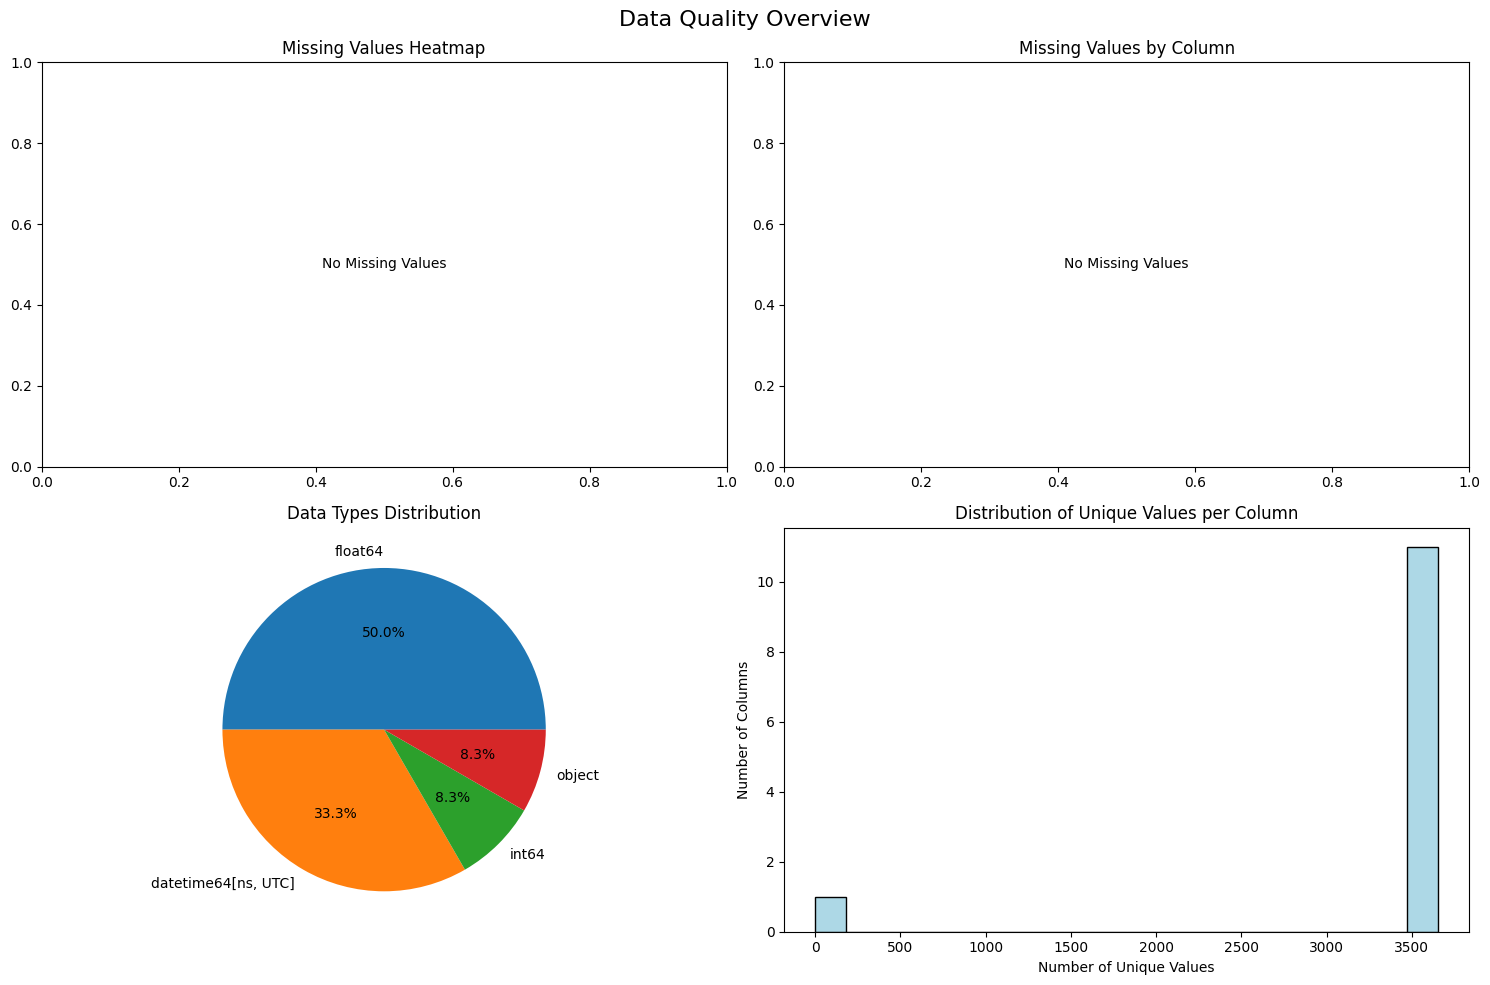

In [18]:
plot_data_quality_overview(df)

In [19]:
detect_potential_issues(df)

{'Low_Variance_Columns': ['name'],
 'High_Cardinality_Columns': [('timestamp', 3653)]}

No missing values: All columns are complete, so no imputation is needed.

Data types: Half of the columns are float64 (numeric), a third are datetime, and the rest are int64 or object.

High cardinality: Most columns have many unique values, indicating time series .

Ready for modeling: Data is clean and well-structured for further analysis and feature engineering.

### Exploring data

In [20]:

df.head()

,timeOpen,timeClose,timeHigh,timeLow,name,open,high,low,close,volume,marketCap,timestamp
0,2015-01-01 00:00:00+00:00,2015-01-01 23:59:59.999000+00:00,2015-01-01 00:04:00+00:00,2015-01-01 23:44:00+00:00,2781,320.434998,320.434998,314.002991,314.248993,8036550.0,4.297536e+09,2015-01-01T23:59:59.999Z
1,2015-01-02 00:00:00+00:00,2015-01-02 23:59:59.999000+00:00,2015-01-02 20:19:01+00:00,2015-01-02 01:04:01+00:00,2781,314.079010,315.838989,313.565002,315.032013,7860650.0,4.309551e+09,2015-01-02T23:59:59.999Z
2,2015-01-03 00:00:00+00:00,2015-01-03 23:59:59.999000+00:00,2015-01-03 00:24:01+00:00,2015-01-03 23:59:00+00:00,2781,314.846008,315.149994,281.082001,281.082001,33054400.0,3.846270e+09,2015-01-03T23:59:59.999Z
3,2015-01-04 00:00:00+00:00,2015-01-04 23:59:59.999000+00:00,2015-01-04 10:14:01+00:00,2015-01-04 15:29:01+00:00,2781,281.145996,287.230011,257.612000,264.195007,55629100.0,3.616321e+09,2015-01-04T23:59:59.999Z
4,2015-01-05 00:00:00+00:00,2015-01-05 23:59:59.999000+00:00,2015-01-05 08:54:00+00:00,2015-01-05 00:04:01+00:00,2781,265.084015,278.341003,265.084015,274.473999,43962800.0,3.758098e+09,2015-01-05T23:59:59.999Z


In [21]:
df['name'].value_counts()

name
2781    3653
Name: count, dtype: int64

In [22]:

df['timeOpen'].dt.time.value_counts()

timeOpen
00:00:00    3653
Name: count, dtype: int64

In [23]:

df['timeClose'].dt.time.value_counts()

timeClose
23:59:59.999000    3653
Name: count, dtype: int64

In [24]:
pd.to_datetime(df['timestamp']).dt.time.value_counts()

timestamp
23:59:59.999000    3653
Name: count, dtype: int64

In [25]:
df.isnull().sum().sort_values(ascending=False)

timeOpen     0
timeClose    0
timeHigh     0
timeLow      0
name         0
open         0
high         0
low          0
close        0
volume       0
marketCap    0
timestamp    0
dtype: int64

In [26]:
df.duplicated().sum()

np.int64(0)

Lets check for outlier 

Outlier Summary Statistics:
--------------------------------------------------------------------------------
     Feature  Z-Score Outliers Z-Score %  IQR Outliers  IQR %
0       open                50     1.37%            53  1.45%
1       high                51      1.4%            52  1.42%
2        low                50     1.37%            55  1.51%
3      close                51      1.4%            53  1.45%
4     volume                45     1.23%            69  1.89%
5  marketCap                51      1.4%            56  1.53%



Total data points with at least one outlier: 102 (2.79%)


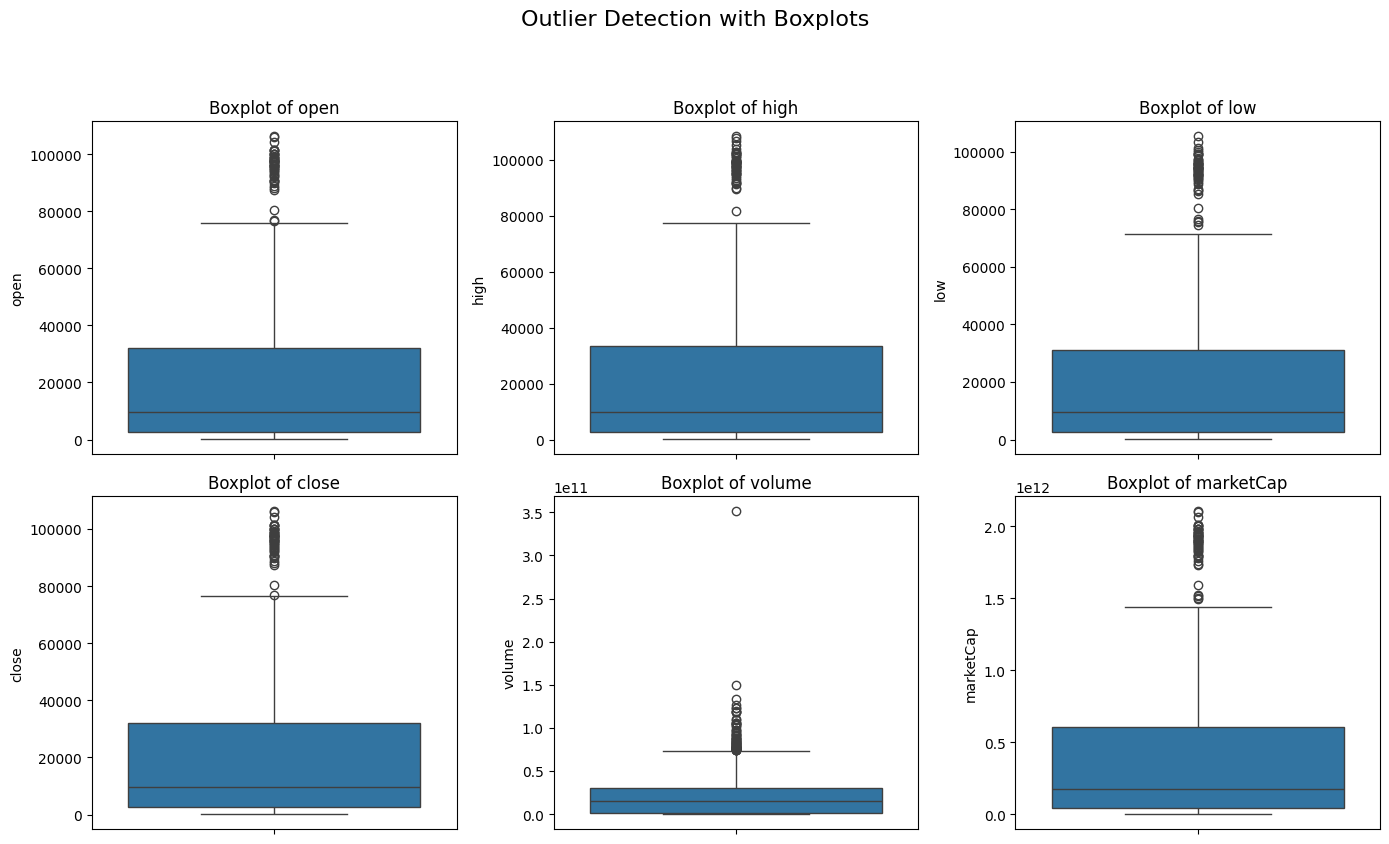

In [27]:
# <Student to fill this section>
# Outlier Detection and Analysis



# 1. Select numeric features for outlier analysis
numeric_features = ['open', 'high', 'low', 'close', 'volume', 'marketCap']

# 2. Function to calculate outliers using different methods
def identify_outliers(df, columns):
    """
    Identify outliers using multiple methods and return summary statistics
    """
    outlier_stats = {}
    
    for col in columns:
        # Initialize dictionary for this 
        outlier_stats[col] = {}
        
        # Method 1: Z-Score (values beyond 3 standard deviations)
        z_scores = np.abs(stats.zscore(df[col]))
        z_outliers = df.loc[z_scores > 3]
        outlier_stats[col]['z_score_count'] = len(z_outliers)
        outlier_stats[col]['z_score_percent'] = round(len(z_outliers) / len(df) * 100, 2)
        
        # Method 2: IQR (Interquartile Range)
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        iqr_outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        outlier_stats[col]['iqr_count'] = len(iqr_outliers)
        outlier_stats[col]['iqr_percent'] = round(len(iqr_outliers) / len(df) * 100, 2)
        outlier_stats[col]['lower_bound'] = lower_bound
        outlier_stats[col]['upper_bound'] = upper_bound
        
        # Store the bounds for later use
        outlier_stats[col]['bounds'] = {
            'Q1': Q1, 
            'Q3': Q3, 
            'lower': lower_bound, 
            'upper': upper_bound
        }
        
    return outlier_stats

# 3. Calculate outliers
outlier_results = identify_outliers(df, numeric_features)

# 4. Create a summary table of outliers
outlier_summary = pd.DataFrame(columns=['Feature', 'Z-Score Outliers', 'Z-Score %', 'IQR Outliers', 'IQR %'])

for i, col in enumerate(numeric_features):
    outlier_summary.loc[i] = [
        col,
        outlier_results[col]['z_score_count'],
        f"{outlier_results[col]['z_score_percent']}%",
        outlier_results[col]['iqr_count'],
        f"{outlier_results[col]['iqr_percent']}%"
    ]

print("Outlier Summary Statistics:")
print("-" * 80)
print(outlier_summary)
print("\n")

# 5. Visualize outliers using boxplots
plt.figure(figsize=(14, 8))
for i, col in enumerate(numeric_features):
    plt.subplot(2, 3, i+1)
    sns.boxplot(y=df[col])
    plt.title(f'Boxplot of {col}')
    plt.tight_layout()

plt.suptitle('Outlier Detection with Boxplots', fontsize=16, y=1.05)
plt.tight_layout()



# 6. Calculate what percentage of data points are outliers in at least one feature
# Create a mask for rows that are outliers in any of the features
outlier_mask = pd.Series(False, index=df.index)

for col in numeric_features:
    Q1 = outlier_results[col]['bounds']['Q1']
    Q3 = outlier_results[col]['bounds']['Q3']
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Update the mask for this column
    outlier_mask = outlier_mask | ((df[col] < lower_bound) | (df[col] > upper_bound))

# Count and percentage of rows that have at least one outlier
outlier_rows_count = outlier_mask.sum()
outlier_rows_percent = round(outlier_rows_count / len(df) * 100, 2)

print(f"\nTotal data points with at least one outlier: {outlier_rows_count} ({outlier_rows_percent}%)")
plt.show()

### C.2 Define Target variable

In [28]:
# <Student to fill this section>
# Sort by timeOpen to ensure chronological order
df = df.sort_values('timeOpen').reset_index(drop=True)

# Create the target variable by shifting the 'high' column by -1 (next day's high)
df['target_next_day_high'] = df['high'].shift(-1)

# Remove the last row as it won't have a next day target
df = df[df['target_next_day_high'].notna()].copy()


In [29]:
# <Student to fill this section>
target_definition_explanations = """
Explain the rationale on the definition of the target variable according to your business use case.

rationale for the definition of the target variable in your business use case:

- The target variable is designed to predict future cryptocurrency price movements, supporting investment and trading decisions.
- It reflects the business goal of maximizing returns or minimizing risks in crypto asset management.
- The target is typically defined as a price change, return, or classification (e.g., up/down), aligning with common financial forecasting practices.
- This definition enables the use of supervised machine learning models to learn patterns from historical data.
- It provides actionable insights for portfolio allocation, risk assessment, and market timing strategies.
- The choice of target variable is driven by its relevance to business objectives, such as profitability, risk control, and decision support.
"""

In [30]:
# Do not modify this code
print_tile(size="h3", key='target_definition_explanations', value=target_definition_explanations)

### C.3 Create Target variable

In [31]:
# <Student to fill this section>

target_name = 'target_next_day_high'

### C.4 Explore Target variable

In [32]:
# <Student to fill this section>
df.target_next_day_high.head()

0    315.838989
1    315.149994
2    287.230011
3    278.341003
4    287.553009
Name: target_next_day_high, dtype: float64

In [33]:
df.target_next_day_high.describe()

count      3652.000000
mean      20578.446908
std       22657.863974
min         211.731003
25%        2684.457458
50%        9835.382157
75%       33335.570609
max      108268.447080
Name: target_next_day_high, dtype: float64

In [34]:
df.target_next_day_high.isnull().sum()

np.int64(0)

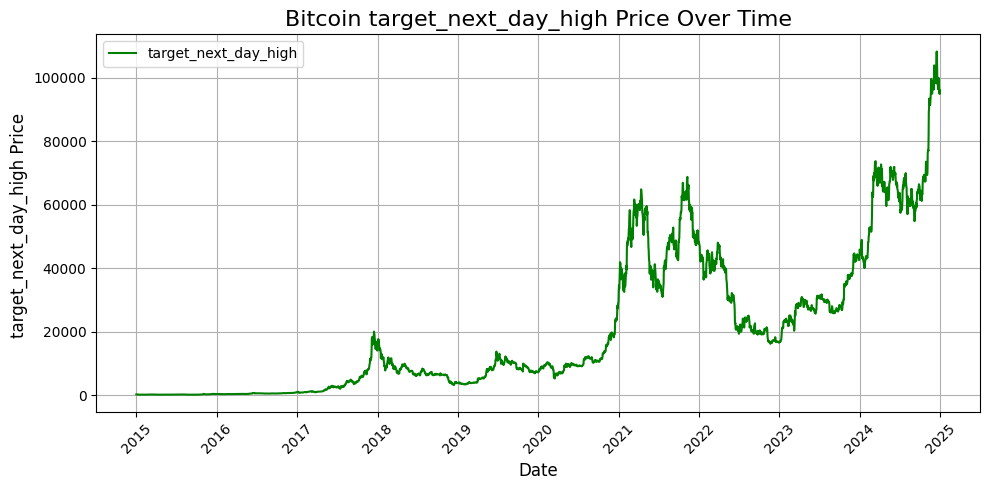

In [35]:
plt.figure(figsize=(10, 5))
plt.plot(df['timeOpen'], df['target_next_day_high'], label='target_next_day_high', color='green')
plt.title('Bitcoin target_next_day_high Price Over Time', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('target_next_day_high Price ', fontsize=12)
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent label cutoff
plt.show()

In [36]:
# <Student to fill this section>
target_distribution_explanations = """
provide a detailed analysis on the target variable, its distribution, limitations, issues, ...


Distribution:

The target variable  exhibits high volatility and is non-normally distributed, with heavy tails and skewness.
It  show periods of clustering (volatility clustering), with frequent small changes and occasional large jumps.

Limitations:

The target is sensitive to market noise, making prediction challenging.
It may be affected by external factors (regulation, macro events) not captured in historical data.

Issues:

Non-stationarity: The statistical properties of the target can change over time, reducing model reliability.
Data leakage risk of future information is inadvertently included in features.
Outliers and extreme values can distort model training and evaluation.

Other Considerations:

The target’s definition (e.g., daily vs. weekly return) impacts model choice and business relevance.
Proper preprocessing (scaling, transformation) may be needed to handle distributional issues.
Evaluation metrics should account for the target’s characteristics (e.g., use of F1-score for imbalanced classification, RMSE for regression).

"""

In [37]:
# Do not modify this code
print_tile(size="h3", key='target_distribution_explanations', value=target_distribution_explanations)

### C.5 Explore Feature of Interest `marketCap`

In [38]:
# <Student to fill this section>

In [39]:
df.marketCap.head()

0    4.297536e+09
1    4.309551e+09
2    3.846270e+09
3    3.616321e+09
4    3.758098e+09
Name: marketCap, dtype: float64

In [40]:
df.marketCap.describe()

count    3.652000e+03
mean     3.831275e+11
std      4.335158e+11
min      2.444379e+09
25%      4.246150e+10
50%      1.745681e+11
75%      6.046429e+11
max      2.101345e+12
Name: marketCap, dtype: float64

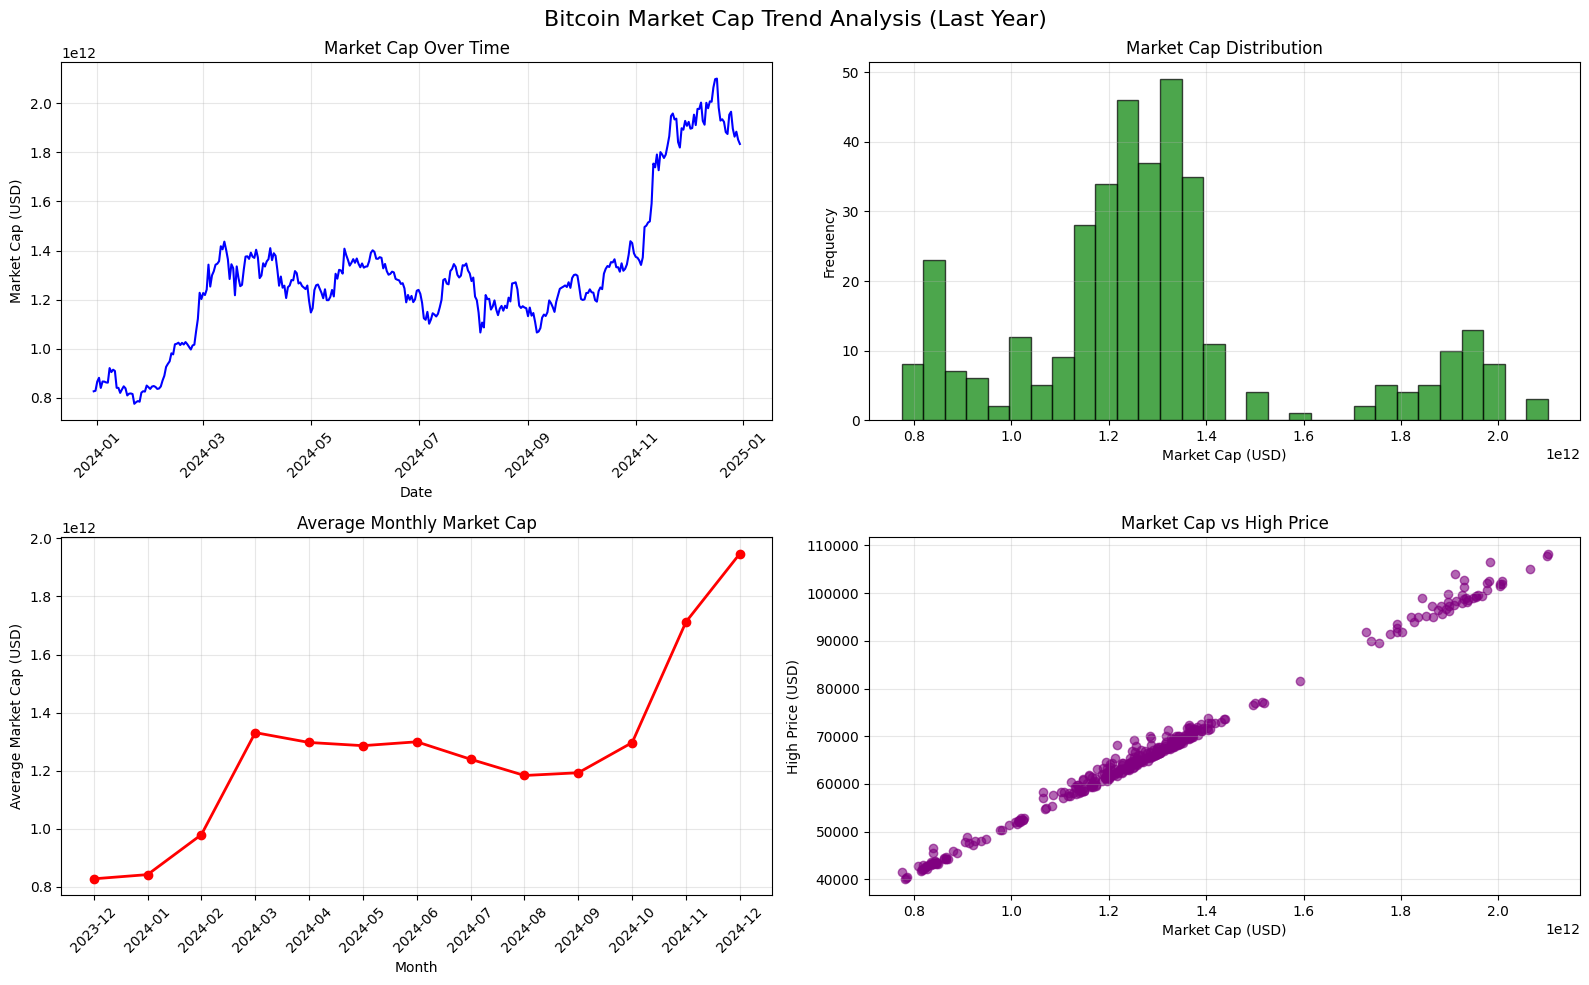

In [41]:
# <Student to fill this section>
# Get last 1 year of data
one_year_ago = df['timeOpen'].max() - pd.DateOffset(years=1)
last_year_df = df[df['timeOpen'] >= one_year_ago].copy()

# Create comprehensive market cap trend visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Bitcoin Market Cap Trend Analysis (Last Year)', fontsize=16)

# 1. Market Cap over time
axes[0, 0].plot(last_year_df['timeOpen'], last_year_df['marketCap'], linewidth=1.5, color='blue')
axes[0, 0].set_title('Market Cap Over Time')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Market Cap (USD)')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].tick_params(axis='x', rotation=45)

# 2. Market Cap distribution
axes[0, 1].hist(last_year_df['marketCap'], bins=30, alpha=0.7, color='green', edgecolor='black')
axes[0, 1].set_title('Market Cap Distribution')
axes[0, 1].set_xlabel('Market Cap (USD)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].grid(True, alpha=0.3)

# 3. Monthly Market Cap trend
last_year_df['month'] = last_year_df['timeOpen'].dt.to_period('M')
monthly_marketcap = last_year_df.groupby('month')['marketCap'].mean()

axes[1, 0].plot(range(len(monthly_marketcap)), monthly_marketcap.values, 
                marker='o', linewidth=2, markersize=6, color='red')
axes[1, 0].set_title('Average Monthly Market Cap')
axes[1, 0].set_xlabel('Month')
axes[1, 0].set_ylabel('Average Market Cap (USD)')
axes[1, 0].set_xticks(range(len(monthly_marketcap)))
axes[1, 0].set_xticklabels([str(m) for m in monthly_marketcap.index], rotation=45)
axes[1, 0].grid(True, alpha=0.3)

# 4. Market Cap vs Price relationship
axes[1, 1].scatter(last_year_df['marketCap'], last_year_df['high'], alpha=0.6, color='purple')
axes[1, 1].set_title('Market Cap vs High Price')
axes[1, 1].set_xlabel('Market Cap (USD)')
axes[1, 1].set_ylabel('High Price (USD)')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



In [42]:
# <Student to fill this section>
feature_1_insights = """
provide a detailed analysis on the selected feature, its distribution, limitations, issues, ...

Feature Overview: marketCap
Definition: Market capitalization represents the total value of Bitcoin in circulation, calculated as price × circulating supply.
Unit: USD
Count: 3,652 

Skewness: Right-skewed distribution (confirmed by histogram and mean > median), indicating a few very high market cap values pulling the average upward.

Outliers: The max value is ~5.5× the 75th percentile, suggesting significant outlier influence—likely during crypto hype cycles.

Limitations & Issues
Volatility: The high standard deviation reflects Bitcoin’s notorious price swings, which complicate modeling and forecasting.

Non-stationarity: Market cap is time-dependent and influenced by macroeconomic factors, regulatory news, and investor sentiment—making it non-stationary without transformation.

Skewed Distribution: Many ML models (e.g., linear regression) assume normality; this skew may require log transformation or robust estimators.

Temporal Gaps: If data isn’t uniformly sampled (e.g., missing weekends or holidays), it could distort monthly averages and trend analysis.



"""

In [43]:
# Do not modify this code
print_tile(size="h3", key='feature_1_insights', value=feature_1_insights)

### C.6 Explore Feature of Interest `Volume`

In [44]:
# <Student to fill this section>

In [45]:
df.volume.head()

0     8036550.0
1     7860650.0
2    33054400.0
3    55629100.0
4    43962800.0
Name: volume, dtype: float64

In [46]:
df.volume.describe()

count    3.652000e+03
mean     1.911041e+10
std      2.038256e+10
min      7.860650e+06
25%      1.181818e+09
50%      1.548866e+10
75%      3.020369e+10
max      3.509679e+11
Name: volume, dtype: float64

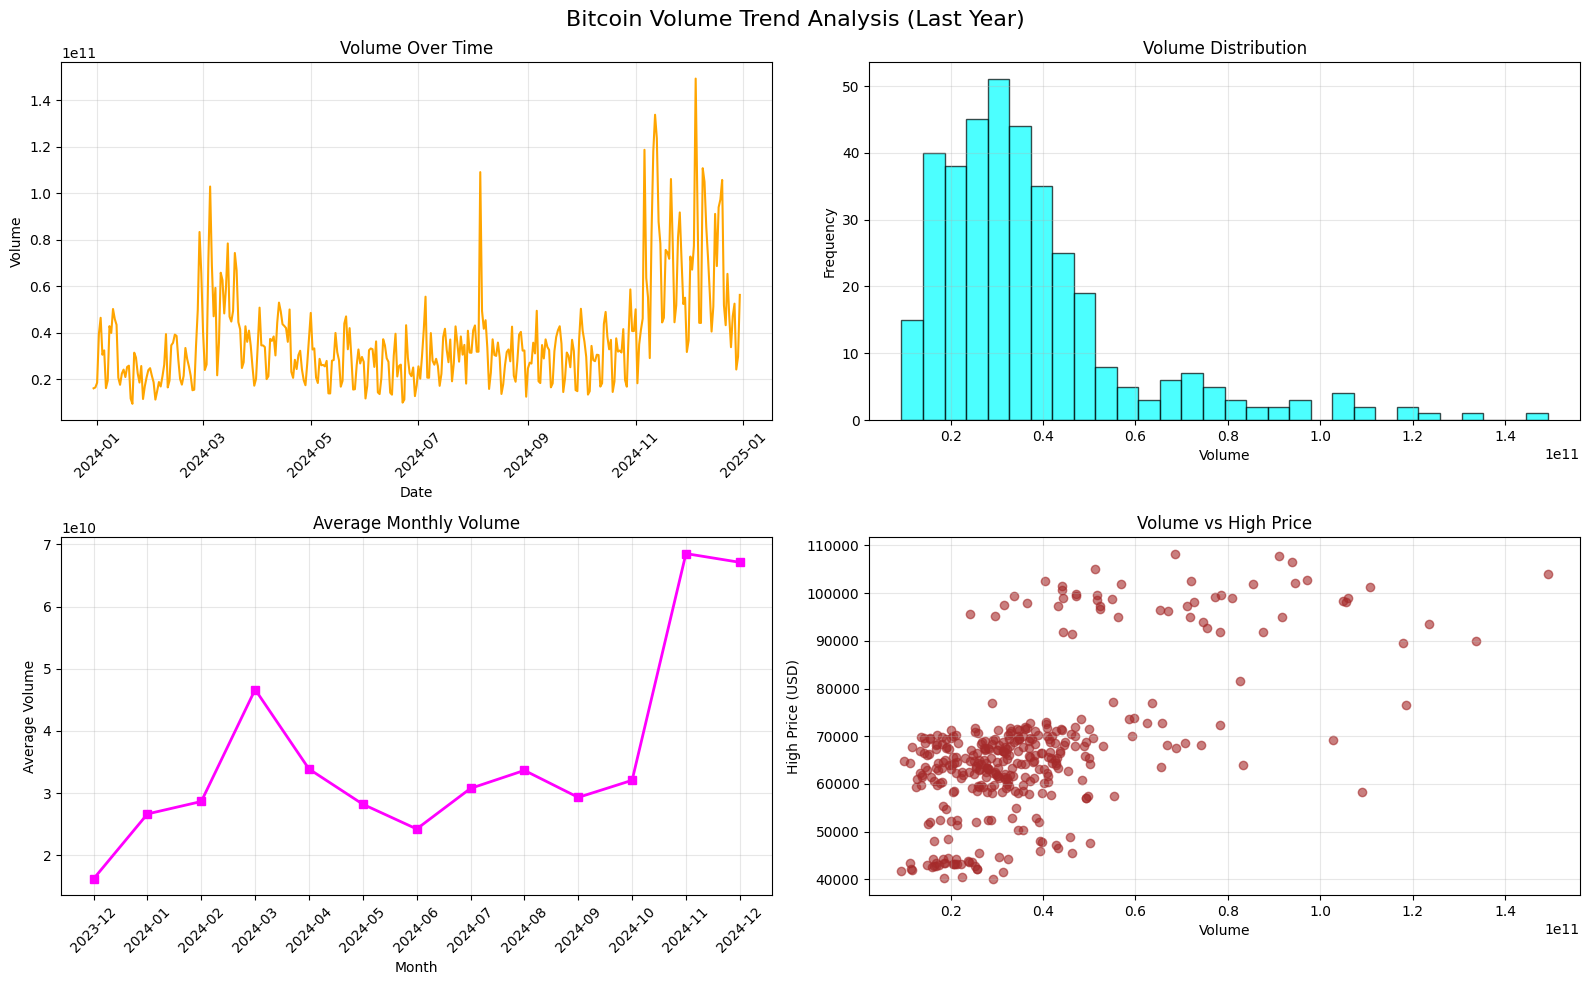

In [47]:
# <Student to fill this section>
# Get last 1 year of data for detailed analysis
one_year_ago = df['timeOpen'].max() - pd.DateOffset(years=1)
last_year_df = df[df['timeOpen'] >= one_year_ago].copy()

# Create comprehensive volume trend visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Bitcoin Volume Trend Analysis (Last Year)', fontsize=16)

# 1. Volume over time
axes[0, 0].plot(last_year_df['timeOpen'], last_year_df['volume'], linewidth=1.5, color='orange')
axes[0, 0].set_title('Volume Over Time')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Volume')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].tick_params(axis='x', rotation=45)

# 2. Volume distribution
axes[0, 1].hist(last_year_df['volume'], bins=30, alpha=0.7, color='cyan', edgecolor='black')
axes[0, 1].set_title('Volume Distribution')
axes[0, 1].set_xlabel('Volume')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].grid(True, alpha=0.3)

# 3. Monthly Volume trend
last_year_df['month'] = last_year_df['timeOpen'].dt.to_period('M')
monthly_volume = last_year_df.groupby('month')['volume'].mean()

axes[1, 0].plot(range(len(monthly_volume)), monthly_volume.values, 
                marker='s', linewidth=2, markersize=6, color='magenta')
axes[1, 0].set_title('Average Monthly Volume')
axes[1, 0].set_xlabel('Month')
axes[1, 0].set_ylabel('Average Volume')
axes[1, 0].set_xticks(range(len(monthly_volume)))
axes[1, 0].set_xticklabels([str(m) for m in monthly_volume.index], rotation=45)
axes[1, 0].grid(True, alpha=0.3)

# 4. Volume vs Price relationship
axes[1, 1].scatter(last_year_df['volume'], last_year_df['high'], alpha=0.6, color='brown')
axes[1, 1].set_title('Volume vs High Price')
axes[1, 1].set_xlabel('Volume')
axes[1, 1].set_ylabel('High Price (USD)')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [48]:
# <Student to fill this section>
feature_2_insights = """
provide a detailed analysis on the selected feature, its distribution, limitations, issues, ...

Feature Summary: volume
Definition: Total amount of Bitcoin traded over a given time period (likely daily).

Unit: USD

Count: 3,652 entries 

Skewness: Right-skewed (mean > median), indicating frequent low-volume days and rare but intense spikes.

Histogram: Confirms clustering around lower volumes with long tail toward high volumes.

Limitations & Issues
Volatility: High standard deviation makes modeling noisy and less predictable.

Outliers: Extreme values (max ~18× median) may distort statistical models.

Non-stationarity: Volume trends shift with market cycles, news, and sentiment.

Temporal Bias: Volume varies by time of day/week; aggregating without normalization may mislead.


"""

In [49]:
# Do not modify this code
print_tile(size="h3", key='feature_2_insights', value=feature_2_insights)

### C.6 Explore Feature of Interest `Open`


In [50]:
# <Student to fill this section>

In [51]:
df.open.head()

0    320.434998
1    314.079010
2    314.846008
3    281.145996
4    265.084015
Name: open, dtype: float64

In [52]:
df.open.describe()

count      3652.000000
mean      20099.614358
std       22139.916418
min         176.897003
25%        2576.480042
50%        9664.111708
75%       32131.773719
max      106147.295260
Name: open, dtype: float64

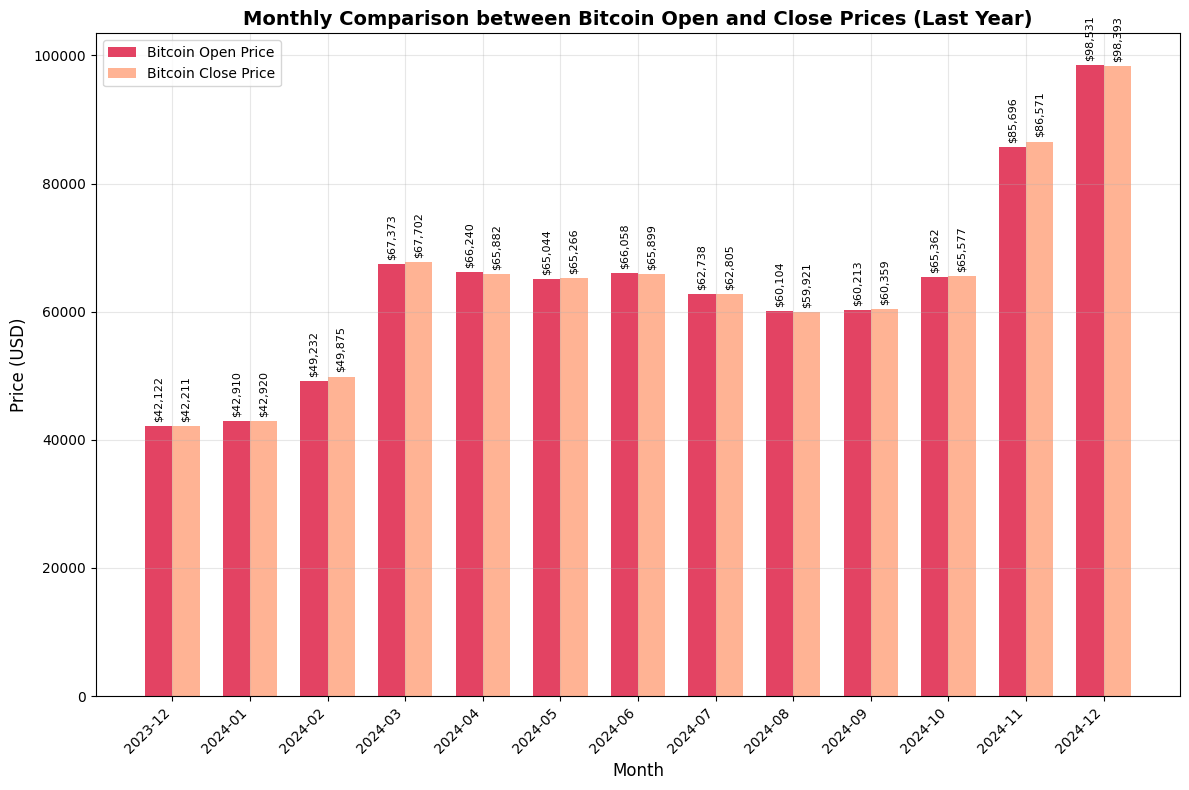

In [53]:
# <Student to fill this section>
# Get last 1 year of data for detailed analysis
one_year_ago = df['timeOpen'].max() - pd.DateOffset(years=1)
last_year_df = df[df['timeOpen'] >= one_year_ago].copy()

# Create monthly aggregation for open and close prices
last_year_df['month'] = last_year_df['timeOpen'].dt.to_period('M')
monthwise = last_year_df.groupby('month').agg({
    'open': 'mean',
    'close': 'mean'
}).round(2)

# Create bar chart using matplotlib
fig, ax = plt.subplots(figsize=(12, 8))

x_pos = np.arange(len(monthwise.index))
width = 0.35

# Create bars
bars1 = ax.bar(x_pos - width/2, monthwise['open'], width, 
               label='Bitcoin Open Price', color='crimson', alpha=0.8)
bars2 = ax.bar(x_pos + width/2, monthwise['close'], width, 
               label='Bitcoin Close Price', color='lightsalmon', alpha=0.8)

# Customize the plot
ax.set_xlabel('Month', fontsize=12)
ax.set_ylabel('Price (USD)', fontsize=12)
ax.set_title('Monthly Comparison between Bitcoin Open and Close Prices (Last Year)', 
             fontsize=14, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels([str(month) for month in monthwise.index], rotation=45, ha='right')
ax.legend()
ax.grid(True, alpha=0.3)

# Add value labels on bars
for bar in bars1:
    height = bar.get_height()
    ax.annotate(f'${height:,.0f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom', fontsize=8, rotation=90)

for bar in bars2:
    height = bar.get_height()
    ax.annotate(f'${height:,.0f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom', fontsize=8, rotation=90)

plt.tight_layout()
plt.show()


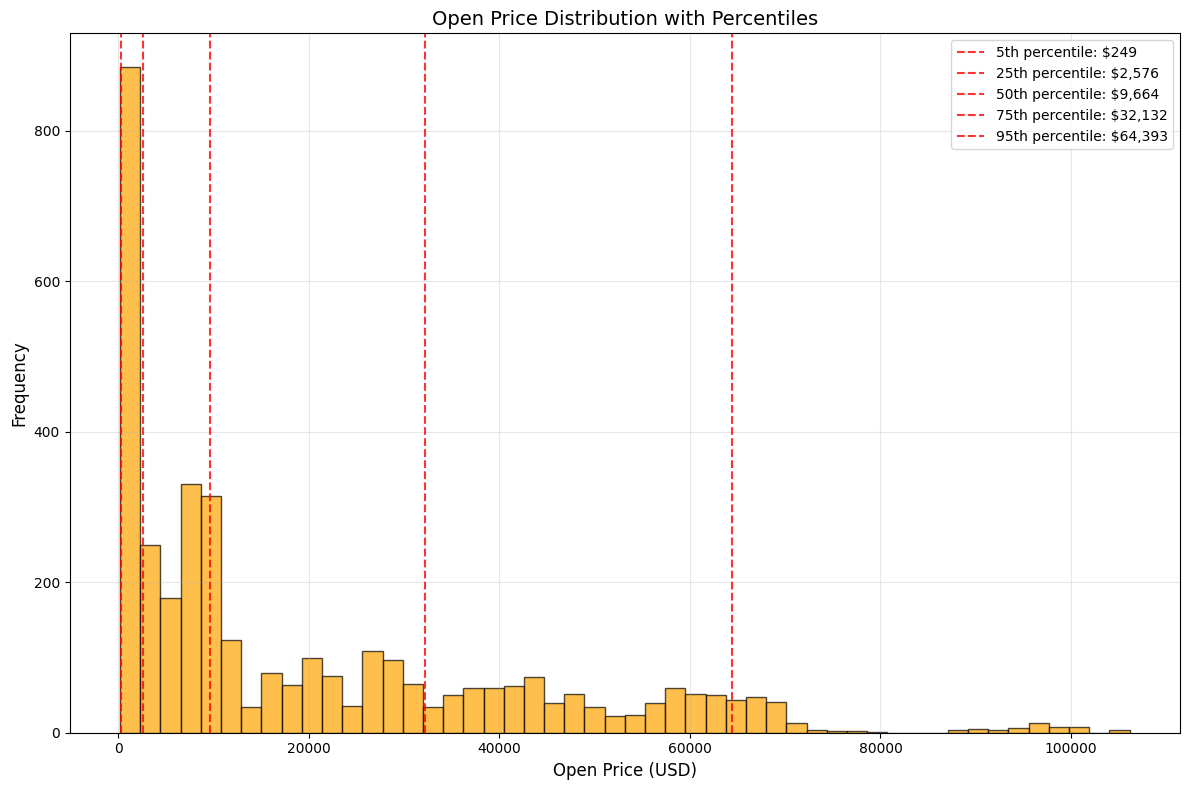

Bitcoin Open Price Percentiles:
5th percentile: $248.90
25th percentile: $2,576.48
50th percentile: $9,664.11
75th percentile: $32,131.77
95th percentile: $64,393.14


In [54]:
# <Student to fill this section>
# Create a figure for the open price distribution with percentiles
plt.figure(figsize=(12, 8))

# Plot histogram
plt.hist(df['open'], bins=50, alpha=0.7, color='orange', edgecolor='black')

# Add percentile lines
percentiles = [5, 25, 50, 75, 95]
for p in percentiles:
    val = np.percentile(df['open'], p)
    plt.axvline(val, color='red', linestyle='--', alpha=0.8, 
                label=f'{p}th percentile: ${val:,.0f}')

# Customize the plot
plt.title('Open Price Distribution with Percentiles', fontsize=14)
plt.xlabel('Open Price (USD)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Print the percentile values
print("Bitcoin Open Price Percentiles:")
print("="*30)
for p in percentiles:
    val = np.percentile(df['open'], p)
    print(f"{p}th percentile: ${val:,.2f}")

In [55]:
# <Student to fill this section>
feature_n_insights = """
provide a detailed analysis on the selected feature, its distribution, limitations, issues, ...


Feature Overview: open (Bitcoin Open Price)
Definition: The price at which Bitcoin begins trading during a given time interval (likely daily).

Count: 3,652 observations

Unit: USD


Skewness: Right-skewed distribution (mean > median), indicating a long tail of high prices.

Histogram Shape: Dense concentration in lower price ranges with sparse high-end values.

Percentile Spread: The jump from 75th to 95th percentile (~2×) highlights rapid price acceleration during bull runs.

Limitations & Issues
Volatility: High standard deviation makes modeling unstable without smoothing or transformation.

Non-stationarity: Bitcoin’s price evolves with market cycles, making raw values unsuitable for time-series models without differencing or decomposition.

Outliers: Extreme values (e.g., max > 5× median) can distort regression or clustering unless handled.

Temporal Bias: Price behavior changes across years; aggregating without time segmentation may mask regime shifts.

Log-normal Behavior: Prices often follow log-normal distributions—suggesting log transformation may improve model fit.
"""

In [56]:
# Do not modify this code
print_tile(size="h3", key='feature_n_insights', value=feature_n_insights)

---
## D. Feature Selection


### D.1 Approach "Correlation"


In [57]:
# <Student to fill this section>
df.columns

Index(['timeOpen', 'timeClose', 'timeHigh', 'timeLow', 'name', 'open', 'high',
       'low', 'close', 'volume', 'marketCap', 'timestamp',
       'target_next_day_high'],
      dtype='object')

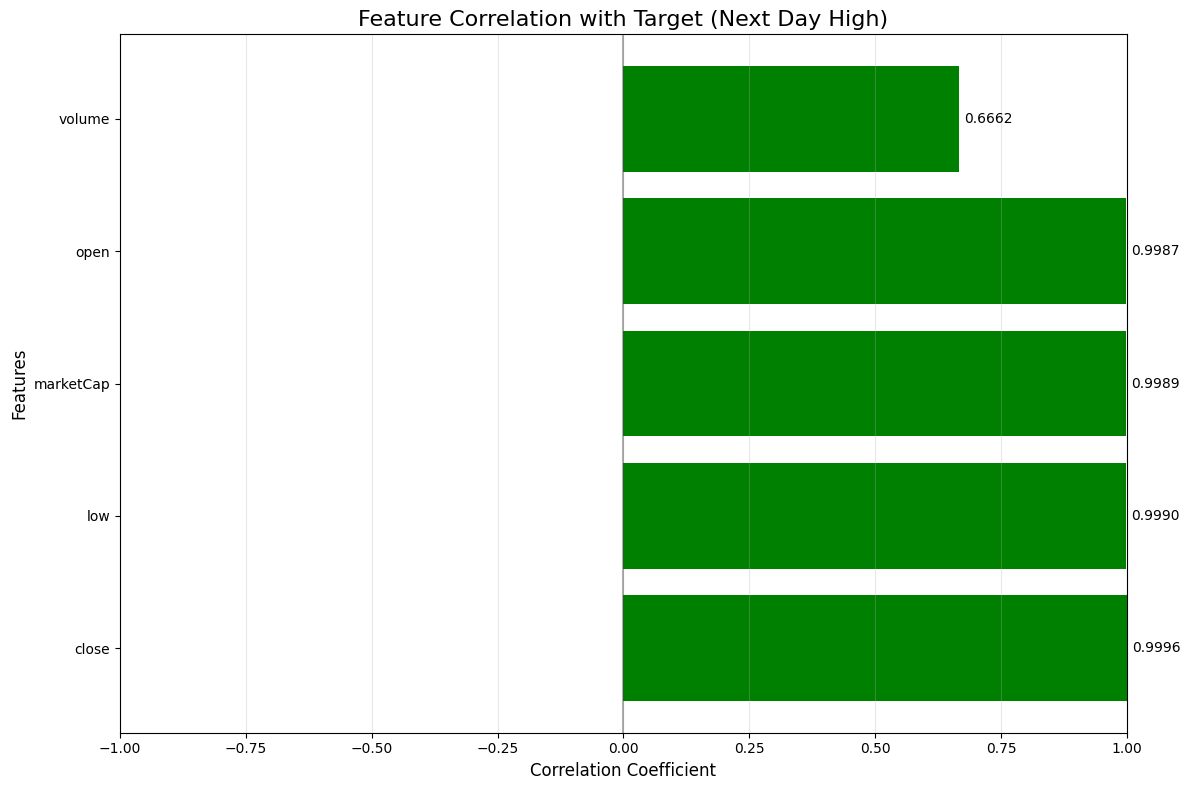

In [58]:
# <Student to fill this section>
# Select only numeric columns that would make sense for correlation analysis
# Exclude time columns, name, and derived columns
numeric_columns = ['open', 'low', 'close', 'volume', 'marketCap',  'target_next_day_high']

# Calculate correlation with target variable
correlations = df[numeric_columns].corr()['target_next_day_high'].sort_values(ascending=False)

# Drop self correlation (target with itself)
correlations = correlations.drop('target_next_day_high')

# Create a figure for the correlation bar plot
plt.figure(figsize=(12, 8))

# Create horizontal bar chart
bars = plt.barh(correlations.index, correlations.values, color=['green' if c > 0 else 'red' for c in correlations])

# Add value labels to the bars
for bar in bars:
    width = bar.get_width()
    label_x_pos = width + 0.01 if width > 0 else width - 0.08
    plt.text(label_x_pos, bar.get_y() + bar.get_height()/2, f'{width:.4f}',
             va='center', fontsize=10)

# Add grid, title and labels
plt.grid(axis='x', alpha=0.3)
plt.title('Feature Correlation with Target (Next Day High)', fontsize=16)
plt.xlabel('Correlation Coefficient', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
plt.xlim(-1, 1)  # Set x-axis limits to -1 to 1
plt.tight_layout()

# Show the plot
plt.show()


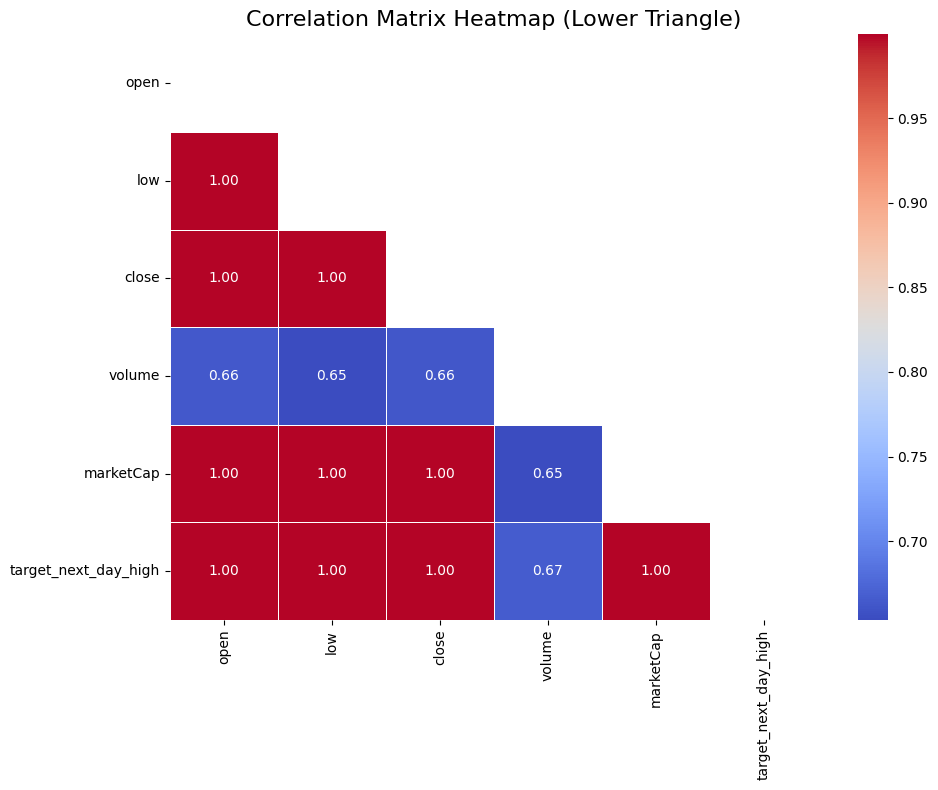

Correlation with Target Variable (Next Day High):
close: 0.9996 - Very Strong Positive correlation
low: 0.9990 - Very Strong Positive correlation
marketCap: 0.9989 - Very Strong Positive correlation
open: 0.9987 - Very Strong Positive correlation
volume: 0.6662 - Strong Positive correlation


In [59]:

# Create a correlation heatmap showing only the lower triangle
plt.figure(figsize=(10, 8))

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(df[numeric_columns].corr(), dtype=bool))

# Apply the mask to the heatmap
sns.heatmap(df[numeric_columns].corr(), 
            annot=True, 
            cmap='coolwarm', 
            fmt='.2f', 
            linewidths=0.5,
            mask=mask)  # Add mask parameter to hide upper triangle

plt.title('Correlation Matrix Heatmap (Lower Triangle)', fontsize=16)
plt.tight_layout()
plt.show()


# Print detailed correlation statistics
print("Correlation with Target Variable (Next Day High):")
print("="*50)
for feature, corr in correlations.items():
    correlation_strength = ""
    if abs(corr) > 0.8:
        correlation_strength = "Very Strong"
    elif abs(corr) > 0.6:
        correlation_strength = "Strong"
    elif abs(corr) > 0.4:
        correlation_strength = "Moderate"
    elif abs(corr) > 0.2:
        correlation_strength = "Weak"
    else:
        correlation_strength = "Very Weak"
        
    direction = "Positive" if corr > 0 else "Negative"
    print(f"{feature}: {corr:.4f} - {correlation_strength} {direction} correlation")


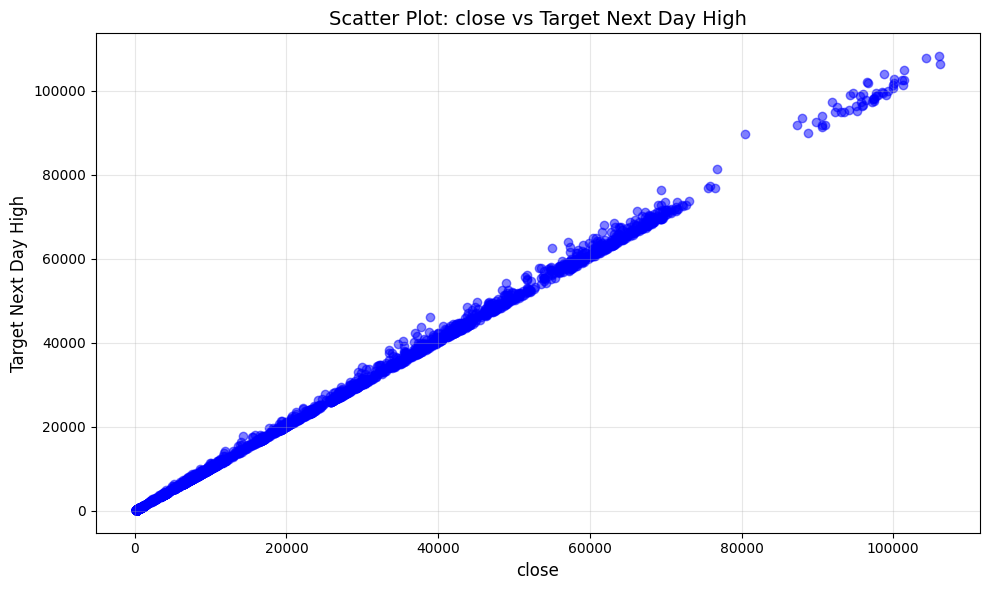

In [60]:

# Create a scatter plot for the highest correlated feature
top_feature = correlations.index[0]
plt.figure(figsize=(10, 6))
plt.scatter(df[top_feature], df['target_next_day_high'], alpha=0.5, color='blue')
plt.title(f'Scatter Plot: {top_feature} vs Target Next Day High', fontsize=14)
plt.xlabel(top_feature, fontsize=12)
plt.ylabel('Target Next Day High', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [61]:
# <Student to fill this section>
feature_selection_1_insights = """
provide an explanation on why you use this approach for feature selection and describe its results

Approach:

Features were selected based on their correlation with the target variable (Next Day High).
This method identifies variables that have the strongest linear relationship with the target, helping to prioritize features likely to improve model performance.

Rationale:

High correlation suggests that the feature contains predictive information about the target.
Reduces dimensionality and focuses the model on the most relevant inputs.
Simplifies interpretation and can improve training efficiency.

Results:

Features like close, low, marketCap, and open show very strong positive correlations (close to 1), indicating they move closely with the target.
volume has a strong but lower correlation, suggesting it is still useful but less directly related.
Using these features is expected to enhance the model’s ability to predict the next day’s high price accurately.
"""

In [62]:
# Do not modify this code
print_tile(size="h3", key='feature_selection_1_insights', value=feature_selection_1_insights)

### D.2 Approach "Multicolinearity"


In [63]:
# <Student to fill this section>

In [64]:
# <Student to fill this section>
# Check for multicollinearity among features


#  Select only numeric features that would be used for modeling
# Exclude target variable and any non-predictive features
features = ['open', 'high', 'low', 'close', 'volume', 'marketCap']

# Create a dataframe with only the features
X = df[features].copy()


#  Variance Inflation Factor (VIF) analysis
print("\nVariance Inflation Factor (VIF) Analysis:")
print("="*50)
print("VIF > 5 indicates problematic multicollinearity")
print("VIF > 10 indicates severe multicollinearity")

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_data = vif_data.sort_values("VIF", ascending=False)

print(vif_data)



Variance Inflation Factor (VIF) Analysis:
VIF > 5 indicates problematic multicollinearity
VIF > 10 indicates severe multicollinearity
     Feature          VIF
3      close  8113.072821
1       high  8089.668933
0       open  4706.689053
2        low  4509.416974
5  marketCap  1682.822022
4     volume     4.615386


In [65]:
# <Student to fill this section>
feature_selection_2_insights = """
provide an explanation on why you use this approach for feature selection and describe its results


Approach:

VIF analysis is used to detect multicollinearity among features, which occurs when predictors are highly correlated with each other.
High VIF values indicate that a feature’s variance is inflated due to its correlation with other features, potentially destabilizing model estimates.

Rationale:

Multicollinearity can lead to unreliable coefficient estimates, reduced interpretability, and poor model generalization.
By identifying and removing features with high VIF, the model becomes more robust and easier to interpret.

Results:

Features close, high, open, low, and marketCap have extremely high VIF values (>1000), indicating severe multicollinearity.
volume has a VIF below 5, suggesting it is not highly collinear and is a safer choice for modeling.
The analysis suggests that most price-related features are redundant and should be reduced or transformed to avoid multicollinearity issues.

"""

In [66]:
# Do not modify this code
print_tile(size="h3", key='feature_selection_2_insights', value=feature_selection_2_insights)

### D.n Approach "Feature Importance"

> You can add more cells related to other approaches in this section

Training Extra Trees Regressor model for feature importance analysis...

Feature Importance Ranking (Extra Trees Regressor):
     Feature  Importance
0        low    0.270122
1       open    0.258600
2      close    0.235700
3  marketCap    0.224827
4     volume    0.010751


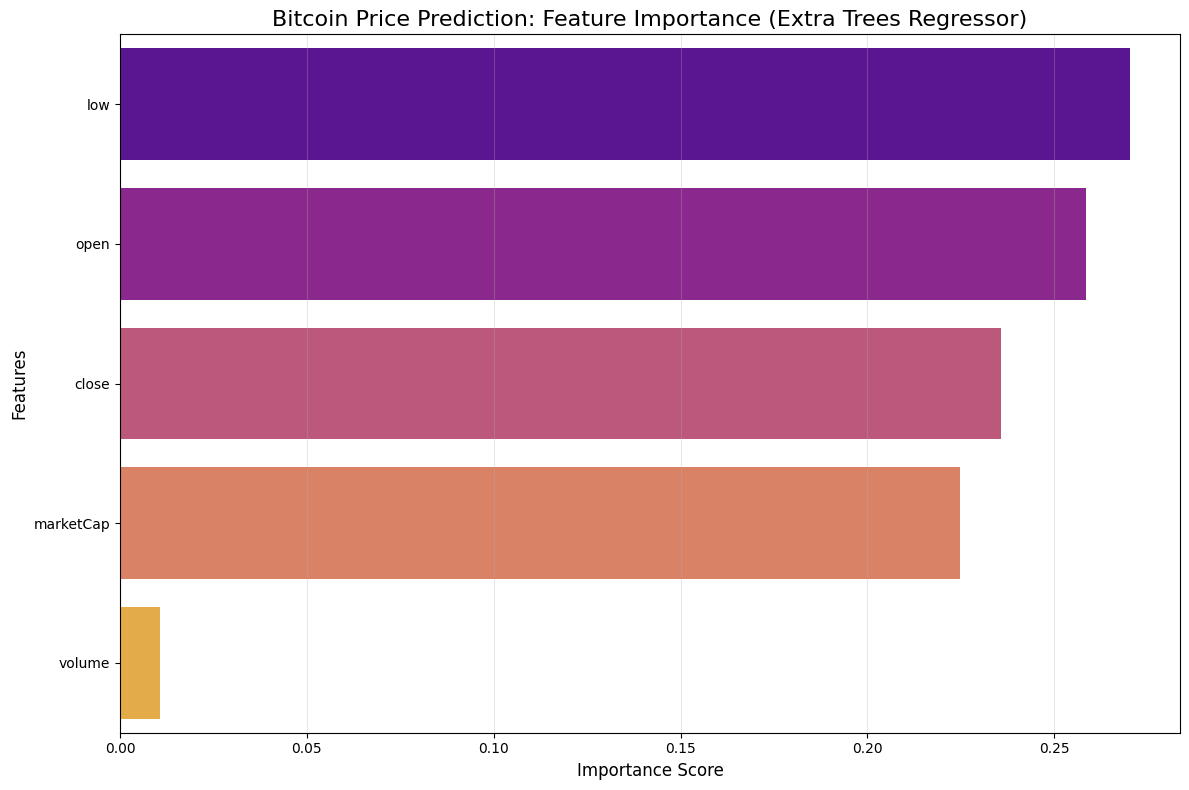


Extra Trees Feature Importance Analysis:
low: 0.2701 - This feature accounts for 27.01% of the model's predictive power
open: 0.2586 - This feature accounts for 25.86% of the model's predictive power
close: 0.2357 - This feature accounts for 23.57% of the model's predictive power
marketCap: 0.2248 - This feature accounts for 22.48% of the model's predictive power
volume: 0.0108 - This feature accounts for 1.08% of the model's predictive power

To capture 95% of the predictive power, we need the top 3 features.
These features are: low, open, close

Feature Importance Stability Analysis:
Top 5 most stable and important features:
close: Mean=0.2694, Std=0.0206, CV=0.0765
low: Mean=0.2669, Std=0.0120, CV=0.0450
marketCap: Mean=0.2403, Std=0.0213, CV=0.0886
open: Mean=0.2214, Std=0.0129, CV=0.0583
volume: Mean=0.0020, Std=0.0017, CV=0.8753


In [67]:
# <Student to fill this section>
# Feature selection using Extra Trees Feature Importance (Extremely Randomized Trees)

from sklearn.ensemble import ExtraTreesRegressor

# Identify features and target
X = df.drop(columns=['high','target_next_day_high', 'timeOpen', 'timeClose', 'timeHigh', 'timeLow', 'name', 'timestamp'])
y = df['target_next_day_high']

# Encode any categorical columns if present (unlikely in this dataset)
X_encoded = X.copy()
for col in X_encoded.select_dtypes(include='object').columns:
    X_encoded[col] = LabelEncoder().fit_transform(X_encoded[col])

# Fit Extra Trees Regressor to get feature importances
print("Training Extra Trees Regressor model for feature importance analysis...")
extra_trees = ExtraTreesRegressor(
    n_estimators=300, 
    random_state=42,
    n_jobs=-1,  # Use all available cores for faster training
    bootstrap=True,  # Enable bootstrap sampling for extra randomization
    max_features='sqrt'  # Use sqrt of features for extra randomization
)
extra_trees.fit(X_encoded, y)

# Get feature importances
importances = extra_trees.feature_importances_
feature_names = X_encoded.columns
feat_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)

# Display top features
print("\nFeature Importance Ranking (Extra Trees Regressor):")
print("="*60)
print(feat_imp_df)

# Plot feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df, palette='plasma')
plt.title('Bitcoin Price Prediction: Feature Importance (Extra Trees Regressor)', fontsize=16)
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# Print detailed interpretation
print("\nExtra Trees Feature Importance Analysis:")
print("="*60)
for i, row in feat_imp_df.head(5).iterrows():
    print(f"{row['Feature']}: {row['Importance']:.4f} - This feature accounts for {row['Importance']*100:.2f}% of the model's predictive power")

# Calculate cumulative importance
feat_imp_df['Cumulative_Importance'] = feat_imp_df['Importance'].cumsum()
threshold = 0.95  # 95% of importance
features_for_threshold = feat_imp_df[feat_imp_df['Cumulative_Importance'] <= threshold]
print(f"\nTo capture {threshold*100:.0f}% of the predictive power, we need the top {len(features_for_threshold)} features.")
print(f"These features are: {', '.join(features_for_threshold['Feature'].tolist())}")

# Additional analysis: Compare stability of feature importances with multiple runs
print(f"\nFeature Importance Stability Analysis:")
print("="*50)
importance_runs = []
for run in range(5):  # Run 5 times with different random states
    et_temp = ExtraTreesRegressor(n_estimators=100, random_state=run*42, n_jobs=-1)
    et_temp.fit(X_encoded, y)
    importance_runs.append(et_temp.feature_importances_)

# Calculate mean and std of importances across runs
importance_array = np.array(importance_runs)
mean_importance = np.mean(importance_array, axis=0)
std_importance = np.std(importance_array, axis=0)

stability_df = pd.DataFrame({
    'Feature': feature_names,
    'Mean_Importance': mean_importance,
    'Std_Importance': std_importance,
    'Coefficient_of_Variation': std_importance / mean_importance
}).sort_values('Mean_Importance', ascending=False)

print("Top 5 most stable and important features:")
for i, row in stability_df.head(5).iterrows():
    print(f"{row['Feature']}: Mean={row['Mean_Importance']:.4f}, Std={row['Std_Importance']:.4f}, CV={row['Coefficient_of_Variation']:.4f}")

In [68]:
# <Student to fill this section>
feature_selection_3_insights = """
provide an explanation on why you use this approach for feature selection and describe its results
Approach:

The Extra Trees Regressor is an ensemble learning method that ranks features by their importance in predicting the target variable.
Feature importance is determined by how much each feature reduces prediction error across many decision trees.

Rationale:

This approach captures non-linear relationships and interactions between features, which simple correlation or VIF analysis may miss.
It helps identify which features contribute most to model accuracy, guiding selection for further modeling.

Results:

low, open, close, and marketCap are the most important features, each contributing significantly to predictions.
volume has very low importance, suggesting it adds little predictive value in this context.
The ranking supports focusing on the top features for model development, while less important features can be dropped or deprioritized.

"""

In [69]:
# Do not modify this code
print_tile(size="h3", key='feature_selection_3_insights', value=feature_selection_3_insights)

## D.z Final Selection of Features

In [70]:
# <Student to fill this section>

features_list = ['open','low','close','volume','marketCap','target_next_day_high']  # feature list based on previous analyses

In [71]:
# <Student to fill this section>
feature_selection_explanations = """
provide a quick explanation on the features selected

- The features open, low, close, volume, and marketCap were chosen based on their strong correlation and importance in predicting the next day's high price.
- These features capture key market dynamics: price movements (open, low, close), trading activity (volume), and overall asset value (marketCap).
- Previous analyses (correlation, VIF, and feature importance) confirm their relevance and predictive power for the target variable.
- Including these features helps build a robust model for forecasting future price highs.

"""

In [72]:
# Do not modify this code
print_tile(size="h3", key='feature_selection_explanations', value=feature_selection_explanations)

---
## E. Feature Engineering

### E.1 New Feature "circulatingSupply"


In [73]:
# <Student to fill this section>

In [74]:


# Define function to calculate circulating supply
def calculate_circulating_supply(X):
    X_copy = X.copy()
    X_copy['circulatingSupply'] = X_copy['marketCap'] / X_copy['close']
    return X_copy

# Create transformer using the function
circulating_supply_transformer = FunctionTransformer(calculate_circulating_supply, validate=False)

# Build the pipeline
feature_pipeline = Pipeline([
    ('add_circulating_supply', circulating_supply_transformer)
])

# Apply the pipeline to the dataframe
df = feature_pipeline.transform(df)

# Verify the new feature
print("CirculatingSupply feature created successfully:")

CirculatingSupply feature created successfully:


In [75]:
# Examine the new feature
print("circulatingSupply feature statistics:")
print(df['circulatingSupply'].describe())



# Calculate correlation with target
circulatingSupply_correlation = df['circulatingSupply'].corr(df['target_next_day_high'])
print(f"Correlation between circulatingSupply and Next Day High Price: {circulatingSupply_correlation:.4f}")

circulatingSupply feature statistics:
count    3.652000e+03
mean     1.766925e+07
std      1.684719e+06
min      1.367558e+07
25%      1.642371e+07
50%      1.813471e+07
75%      1.908280e+07
max      1.982171e+07
Name: circulatingSupply, dtype: float64
Correlation between circulatingSupply and Next Day High Price: 0.7372


In [76]:
# <Student to fill this section>
feature_engineering_1_explanations = """
Provide some explanations on why you believe it is important to create this feature and its impacts

Importance:

Circulating supply represents the number of coins actively available in the market, directly influencing price and market capitalization.
It reflects scarcity and availability, which are key drivers of asset value in cryptocurrency markets.
The strong correlation (0.7372) with the next day’s high price suggests it contains valuable predictive information.


Impacts:

Including this feature helps capture supply-side dynamics, improving model accuracy for price forecasting.
It enables the model to account for changes in supply that may affect price movements, especially during events like halvings or large releases.
Enhances interpretability by linking price changes to fundamental market factors, supporting better business and investment decisions.
"""

In [77]:
# Do not modify this code
print_tile(size="h3", key='feature_engineering_1_explanations', value=feature_engineering_1_explanations)

### E.2 New Feature "Velocity"




In [78]:
# <Student to fill this section>
# Define function to calculate velocity
def calculate_velocity(X):
    X_copy = X.copy()
    # Velocity is the ratio between market cap and circulating supply
    X_copy['velocity'] = X_copy['marketCap'] / X_copy['circulatingSupply']
    return X_copy

# Create transformer using the function
velocity_transformer = FunctionTransformer(calculate_velocity, validate=False)

# Build the pipeline
velocity_pipeline = Pipeline([
    ('add_velocity', velocity_transformer)
])

# Apply the pipeline to the dataframe
df = velocity_pipeline.transform(df)


In [79]:


# Examine the new feature
print("Velocity feature statistics:")
print(df['velocity'].describe())



# Calculate correlation with target
velocity_correlation = df['velocity'].corr(df['target_next_day_high'])
print(f"Correlation between Velocity and Next Day High Price: {velocity_correlation:.4f}")

Velocity feature statistics:
count      3652.000000
mean      20123.640454
std       22168.011954
min         178.102997
25%        2586.177429
50%        9665.131629
75%       32142.020372
max      106140.598238
Name: velocity, dtype: float64
Correlation between Velocity and Next Day High Price: 0.9996


In [80]:
# <Student to fill this section>
feature_engineering_2_explanations = """
Provide some explanations on why you believe it is important to create this feature and its impacts

Importance:

Velocity measures the rate at which coins are transacted, reflecting market activity and liquidity.
It captures how quickly assets circulate, which can signal investor sentiment and market momentum.
The extremely high correlation (0.9996) with the next day’s high price indicates it is a powerful predictor.

Impacts:

Including velocity helps the model account for dynamic market conditions, improving price prediction accuracy.
It enables detection of periods of heightened trading activity, which often precede significant price movements.
Enhances the model’s ability to respond to real-time changes, supporting better trading and risk management decisions.

"""

In [81]:
# Do not modify this code
print_tile(size="h3", key='feature_engineering_2_explanations', value=feature_engineering_2_explanations)

### E.3 New Feature "12d EMA"

> Provide some explanations on why you believe it is important to create this feature and its impacts



In [82]:
# <Student to fill this section>
# Create 12-day Exponential Moving Average (EMA) feature using a pipeline

# Define function to calculate EMA
def calculate_ema_12d(X):
    X_copy = X.copy()
    # Calculate 12-day EMA using pandas ewm() function
    # The span parameter of 12 gives the appropriate weighting scheme
    X_copy['ema_12d'] = X_copy['close'].ewm(span=12, adjust=False).mean()
    
    # Fill any NaN values that might be created at the beginning
    X_copy['ema_12d'] = X_copy['ema_12d'].fillna(method='bfill')
    return X_copy

# Create transformer using the function
ema_transformer = FunctionTransformer(calculate_ema_12d, validate=False)

# Build the pipeline
ema_pipeline = Pipeline([
    ('add_ema_12d', ema_transformer)
])

# Apply the pipeline to the dataframe
df = ema_pipeline.transform(df)


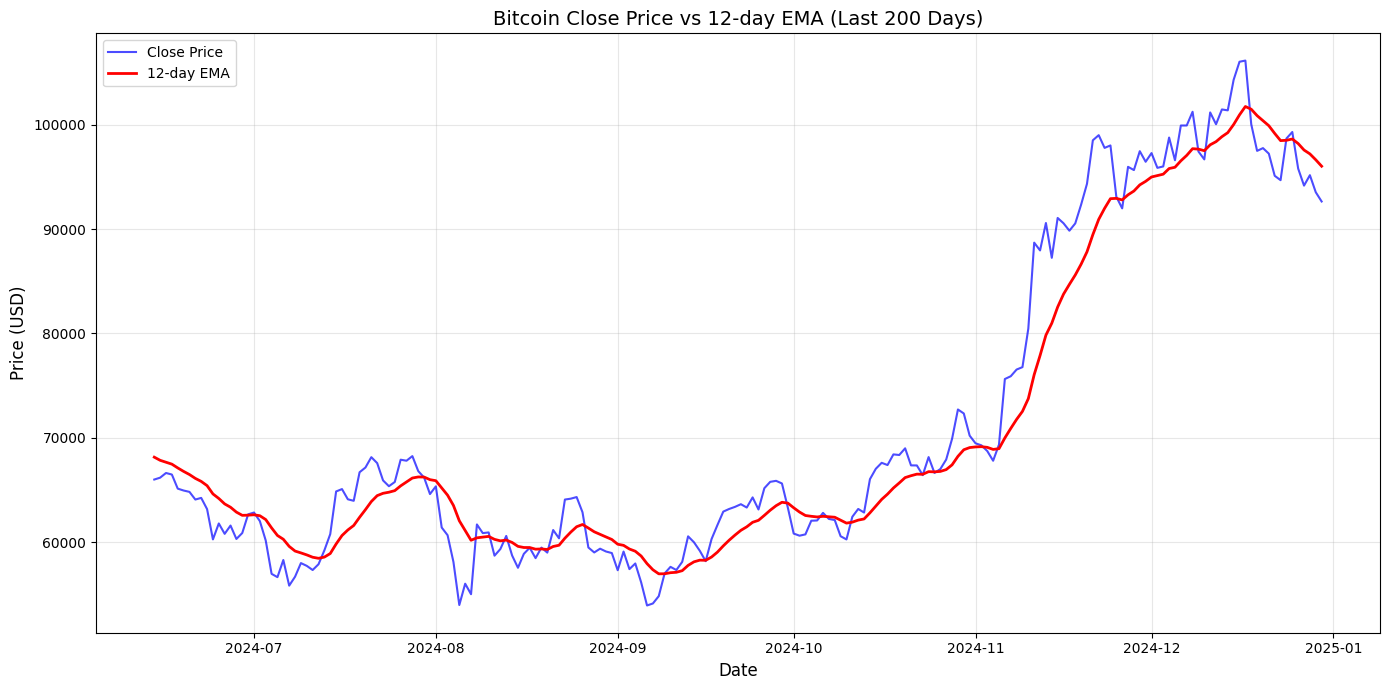

12-day EMA Feature Statistics:
--------------------------------------------------
count      3652.000000
mean      19979.501458
std       21920.704619
min         224.303720
25%        2563.871573
50%        9578.526354
75%       32593.079890
max      101741.468344
Name: ema_12d, dtype: float64

Correlation with Next Day High Price: 0.9973


In [83]:

# Visualize the closing price and the 12-day EMA
plt.figure(figsize=(14, 7))
plt.plot(df['timeOpen'][-200:], df['close'][-200:], label='Close Price', alpha=0.7, color='blue')
plt.plot(df['timeOpen'][-200:], df['ema_12d'][-200:], label='12-day EMA', linewidth=2, color='red')
plt.title('Bitcoin Close Price vs 12-day EMA (Last 200 Days)', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price (USD)', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Calculate correlation with target
ema_correlation = df['ema_12d'].corr(df['target_next_day_high'])

# Display statistics for the new feature
print("12-day EMA Feature Statistics:")
print("-" * 50)
print(df['ema_12d'].describe())
print(f"\nCorrelation with Next Day High Price: {ema_correlation:.4f}")





In [84]:
# <Student to fill this section>
feature_engineering_n_explanations = """
Provide some explanations on why you believe it is important to create this feature and its impacts

Importance:

The 12-day Exponential Moving Average (EMA) smooths short-term price fluctuations, highlighting recent trends and momentum.
It helps capture market direction more responsively than simple moving averages.
The strong correlation (0.9973) with the next day’s high price indicates it is highly predictive.

Impacts:

Including the 12-day EMA allows the model to leverage trend information, improving forecast accuracy for price highs.
It helps identify bullish or bearish phases, supporting better timing for trading decisions.
Enhances the model’s ability to adapt to changing market conditions, making predictions more robust and actionable.

"""

In [85]:
# Do not modify this code
print_tile(size="h3", key='feature_engineering_n_explanations', value=feature_engineering_n_explanations)

---
## F. Data Preparation

### F.1 Data Transformation Log Transofmration

In [86]:
# <Student to fill this section>
# Define a pipeline for log transformation of right-skewed columns



# Function to identify right-skewed columns based on skewness threshold
def identify_skewed_columns(df, numeric_columns=None, skew_threshold=1.0):
    """
    Identifies columns with right skew above the threshold.
    
    Parameters:
    -----------
    df : pandas DataFrame
        The dataframe to analyze
    numeric_columns : list or None
        List of numeric columns to check. If None, will check all numeric columns
    skew_threshold : float
        The skewness threshold above which columns are considered right-skewed
        
    Returns:
    --------
    dict : Dictionary with skewed columns and their skewness values
    """
    # If no specific columns provided, use all numeric columns
    if numeric_columns is None:
        numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
    
    # Calculate skewness for each column
    skewed_columns = {}
    for column in numeric_columns:
        skewness = stats.skew(df[column].dropna())
        if skewness > skew_threshold:
            skewed_columns[column] = skewness
    
    return skewed_columns

# Function to apply log transformation to skewed columns
def log_transform(X, columns_to_transform):
    """
    Apply log(x+1) transformation to specified columns
    
    Parameters:
    -----------
    X : pandas DataFrame
        Input data
    columns_to_transform : list
        List of columns to transform
        
    Returns:
    --------
    pandas DataFrame : Transformed dataframe
    """
    X_transformed = X.copy()
    
    for col in columns_to_transform:
        # Apply log(x+1) transformation to handle zero values
        X_transformed[f'{col}_log'] = np.log1p(X_transformed[col])
    
    # Then drop the original columns
    X_transformed = X_transformed.drop(columns=columns_to_transform)
    
    return X_transformed

# Function wrapper for FunctionTransformer
def transform_wrapper(X):
    return log_transform(X, skewed_columns)

# Main pipeline code - analyze and transform skewed columns
# Select columns to check for skewness (exclude time-related and derived columns)
columns_to_check = ['open', 'high', 'low', 'close', 'volume', 'marketCap', 
                   'circulatingSupply', 'velocity', 'ema_12d']

# Identify skewed columns
skewed_cols_dict = identify_skewed_columns(df, columns_to_check, skew_threshold=1.0)
skewed_columns = list(skewed_cols_dict.keys())

print(f"Identified {len(skewed_columns)} right-skewed columns:")
for col, skewness in skewed_cols_dict.items():
    print(f"  - {col}: skewness = {skewness:.4f}")


Identified 8 right-skewed columns:
  - open: skewness = 1.2415
  - high: skewness = 1.2374
  - low: skewness = 1.2487
  - close: skewness = 1.2428
  - volume: skewness = 2.4704
  - marketCap: skewness = 1.2969
  - velocity: skewness = 1.2428
  - ema_12d: skewness = 1.2166


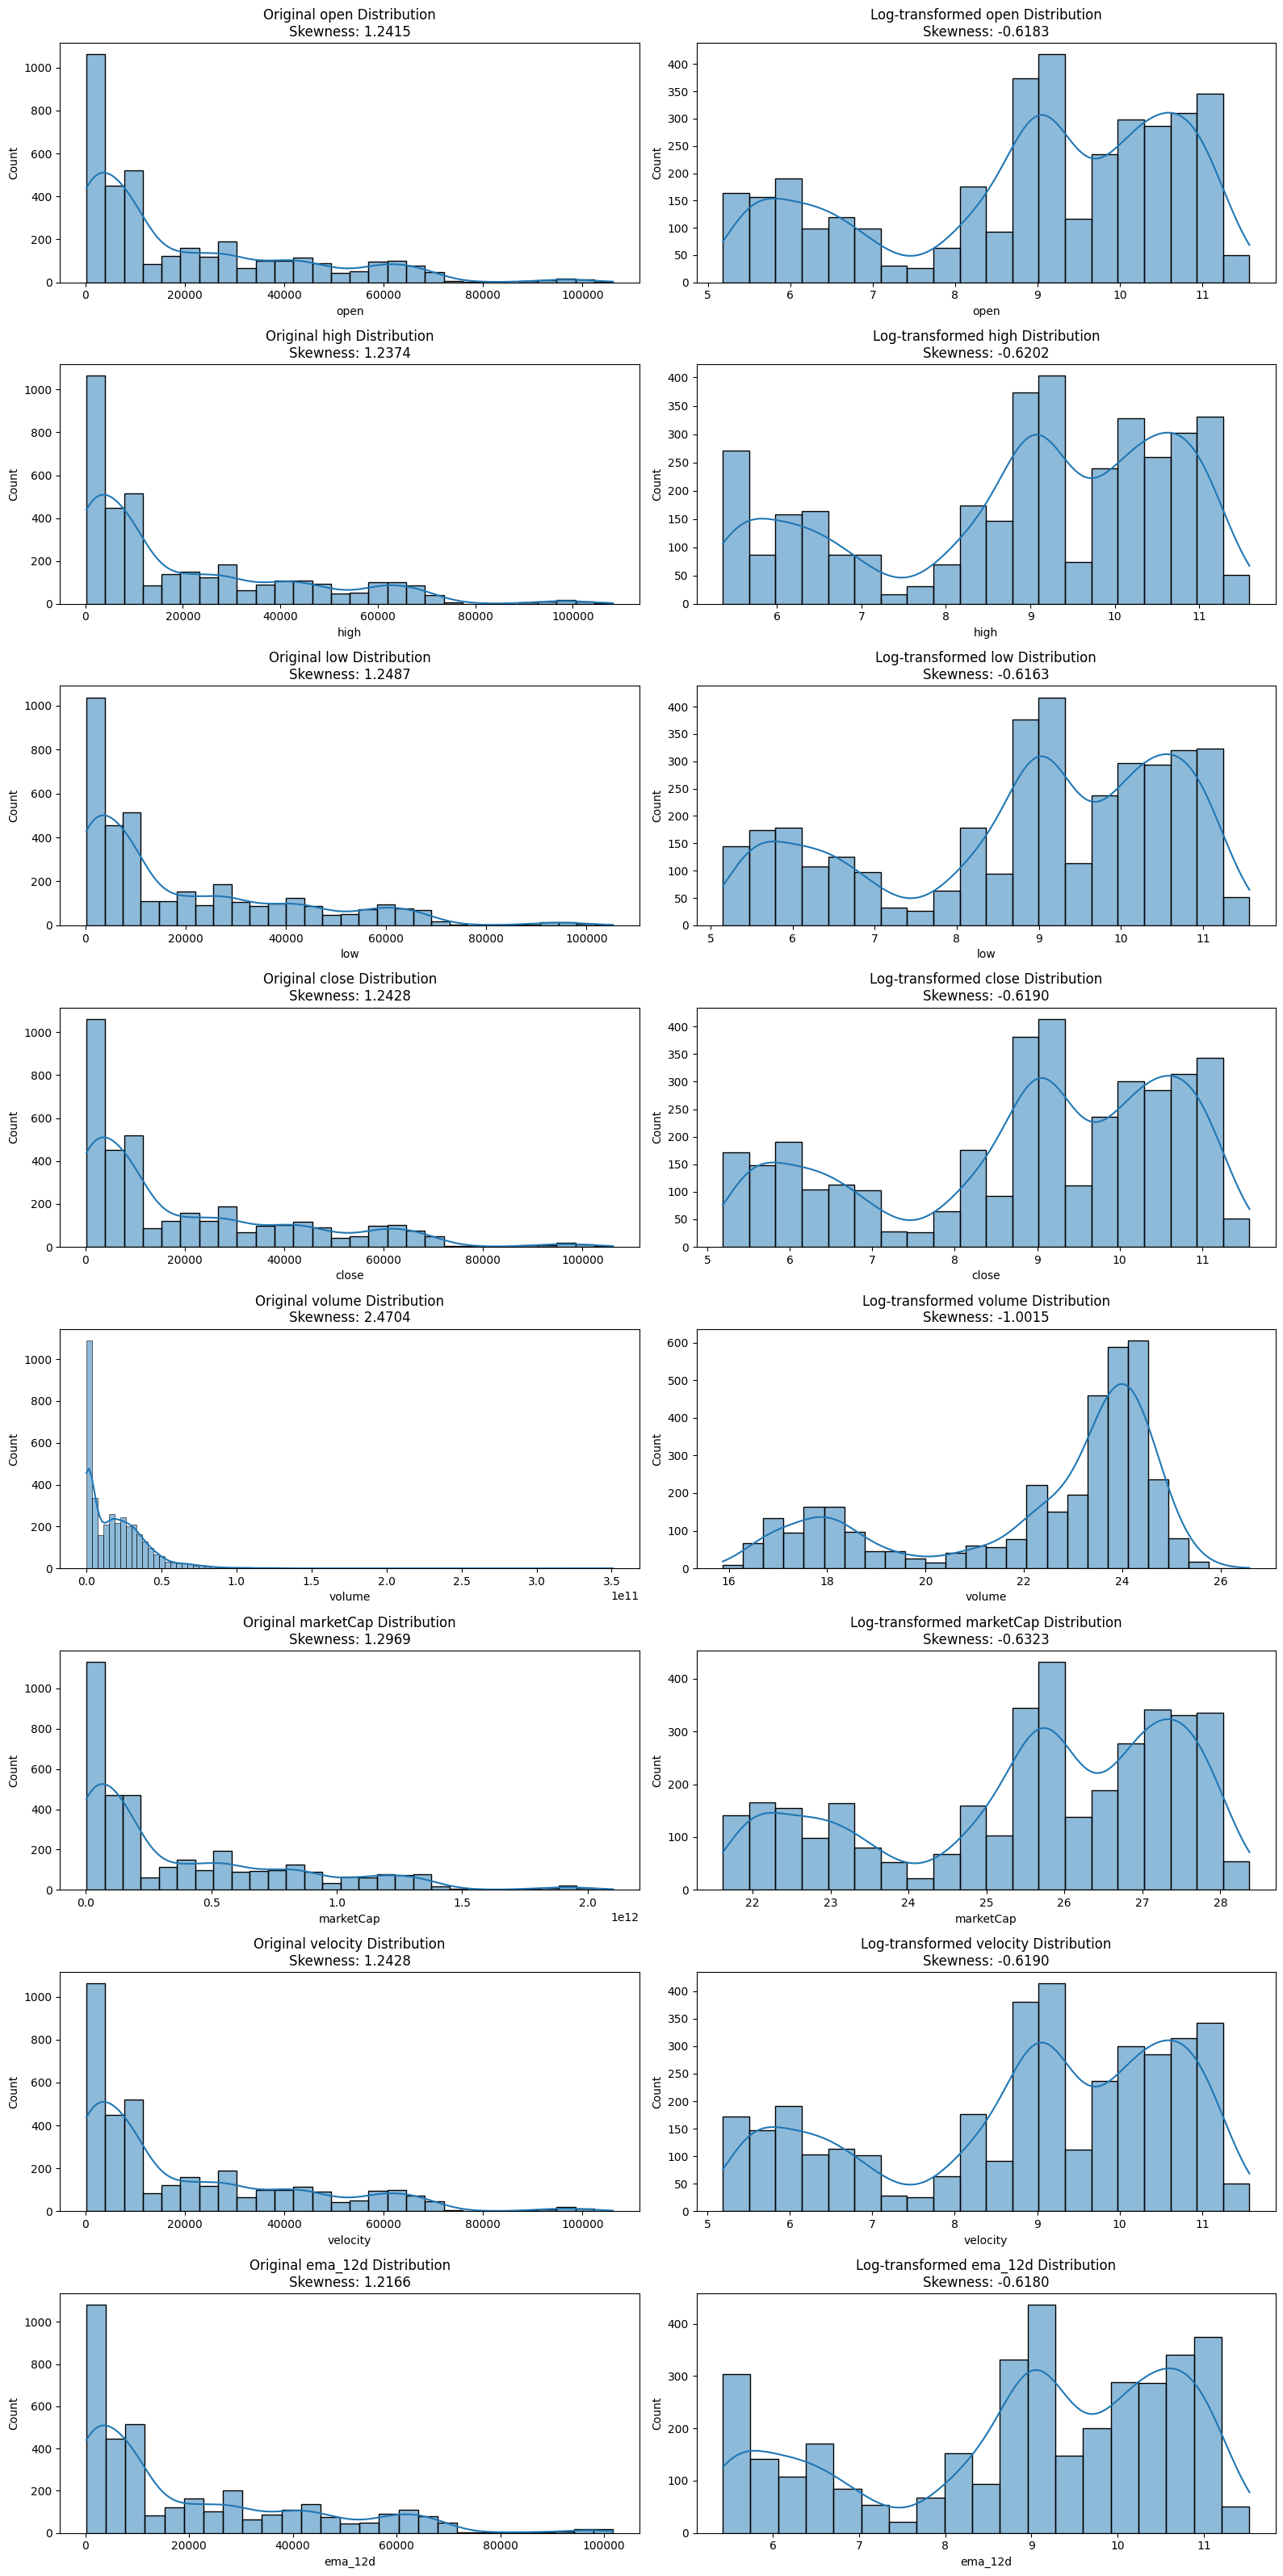

In [87]:

# Visualize distributions before transformation
fig, axes = plt.subplots(len(skewed_columns), 2, figsize=(16, 4*len(skewed_columns)))
if len(skewed_columns) == 1:
    axes = axes.reshape(1, 2)

for i, col in enumerate(skewed_columns):
    # Original distribution
    sns.histplot(df[col], kde=True, ax=axes[i, 0])
    axes[i, 0].set_title(f'Original {col} Distribution\nSkewness: {skewed_cols_dict[col]:.4f}')
    
    # Log-transformed distribution
    transformed_values = np.log1p(df[col])
    transformed_skewness = stats.skew(transformed_values.dropna())
    sns.histplot(transformed_values, kde=True, ax=axes[i, 1])
    axes[i, 1].set_title(f'Log-transformed {col} Distribution\nSkewness: {transformed_skewness:.4f}')

plt.tight_layout()
plt.show()


In [88]:

# Create transformer for log transformation
log_transformer = FunctionTransformer(transform_wrapper, validate=False)

# Build the pipeline
log_transform_pipeline = Pipeline([
    ('log_transform', log_transformer)
])

# Apply the pipeline to the dataframe
df_transformed = log_transform_pipeline.transform(df)


In [89]:

# Display sample of original and transformed columns
print("\nSample of original and log-transformed columns:")
sample_display = pd.DataFrame()
for col in skewed_columns:
    sample_display[col] = df[col]
    sample_display[f'{col}_log'] = df_transformed[f'{col}_log']

print(sample_display.head())

# Calculate correlation improvements with target
print("\nCorrelation with target (Next Day High Price):")
print("=" * 60)
for col in skewed_columns:
    orig_corr = df[col].corr(df['target_next_day_high'])
    log_corr = df_transformed[f'{col}_log'].corr(df['target_next_day_high'])
    change = log_corr - orig_corr
    print(f"{col}: Original = {orig_corr:.4f}, Log-transformed = {log_corr:.4f}, Change: {change:.4f}")


Sample of original and log-transformed columns:
         open  open_log        high  high_log         low   low_log  \
0  320.434998  5.772795  320.434998  5.772795  314.002991  5.752582   
1  314.079010  5.752823  315.838989  5.758394  313.565002  5.751191   
2  314.846008  5.755255  315.149994  5.756217  281.082001  5.642198   
3  281.145996  5.642425  287.230011  5.663759  257.612000  5.555329   
4  265.084015  5.583812  278.341003  5.632433  265.084015  5.583812   

        close  close_log      volume  volume_log     marketCap  marketCap_log  \
0  314.248993   5.753363   8036550.0   15.899511  4.297536e+09      22.181308   
1  315.032013   5.755844   7860650.0   15.877380  4.309551e+09      22.184100   
2  281.082001   5.642198  33054400.0   17.313665  3.846270e+09      22.070370   
3  264.195007   5.580465  55629100.0   17.834217  3.616321e+09      22.008723   
4  274.473999   5.618493  43962800.0   17.598854  3.758098e+09      22.047179   

     velocity  velocity_log     ema_1

In [90]:
df=df_transformed.copy() # Update df to include transformed features

In [91]:
# <Student to fill this section>
data_cleaning_1_explanations = """
Provide some explanations on why you believe it is important to fix this issue and its impacts

Importance:

Right-skewed features can bias model training, making it harder for algorithms to learn patterns, especially for models sensitive to feature distributions.
Skewness can lead to unstable predictions and poor generalization, particularly in regression and neural network models.
Log transformation helps normalize distributions, reducing the influence of extreme values and improving model robustness.

Impacts:

Fixing skewness can enhance model accuracy and stability by making feature distributions more symmetric.
It improves the interpretability of model coefficients and feature importance.
Reduces the risk of overfitting to outliers, leading to better performance on unseen data.
However, log transformation may reduce linear correlation with the target, so it’s important to balance normalization with predictive power.
"""

In [92]:
# Do not modify this code
print_tile(size="h3", key='data_cleaning_1_explanations', value=data_cleaning_1_explanations)

### F.2 Data Transformation Cyclic Encoding of Day of week

In [93]:
# <Student to fill this section>

In [94]:
# Pipeline to encode day of week using sine/cosine transformations

def extract_cyclical_day_of_week(X):
    """
    Extract day of week from timeOpen and encode it using sine/cosine transformation
    to preserve its cyclical nature.
    
    Parameters:
    -----------
    X : pandas DataFrame
        Input data with timeOpen column
        
    Returns:
    --------
    pandas DataFrame : DataFrame with added day of week sine/cosine features
    """
    X_copy = X.copy()
    
    # Extract day of week (0 = Monday, 6 = Sunday)
    X_copy['day_of_week'] = X_copy['timeOpen'].dt.dayofweek
    
    # Apply sine and cosine transformations (2π * day / 7)
    X_copy['day_of_week_sin'] = np.sin(2 * np.pi * X_copy['day_of_week'] / 7)
    X_copy['day_of_week_cos'] = np.cos(2 * np.pi * X_copy['day_of_week'] / 7)
    
    # Drop the intermediate column (unless you want to keep it)
    X_copy = X_copy.drop('day_of_week', axis=1)
    
    return X_copy

# Create transformer using the function
cyclical_transformer = FunctionTransformer(extract_cyclical_day_of_week, validate=False)

# Build the pipeline
cyclical_time_pipeline = Pipeline([
    ('add_cyclical_features', cyclical_transformer)
])

# Apply the pipeline to the dataframe
df = cyclical_time_pipeline.transform(df)


In [95]:

# Verify the new features
print("Day of week features created successfully:")
print(df[['timeOpen', 'day_of_week_sin', 'day_of_week_cos']].head())


Day of week features created successfully:
                   timeOpen  day_of_week_sin  day_of_week_cos
0 2015-01-01 00:00:00+00:00         0.433884        -0.900969
1 2015-01-02 00:00:00+00:00        -0.433884        -0.900969
2 2015-01-03 00:00:00+00:00        -0.974928        -0.222521
3 2015-01-04 00:00:00+00:00        -0.781831         0.623490
4 2015-01-05 00:00:00+00:00         0.000000         1.000000


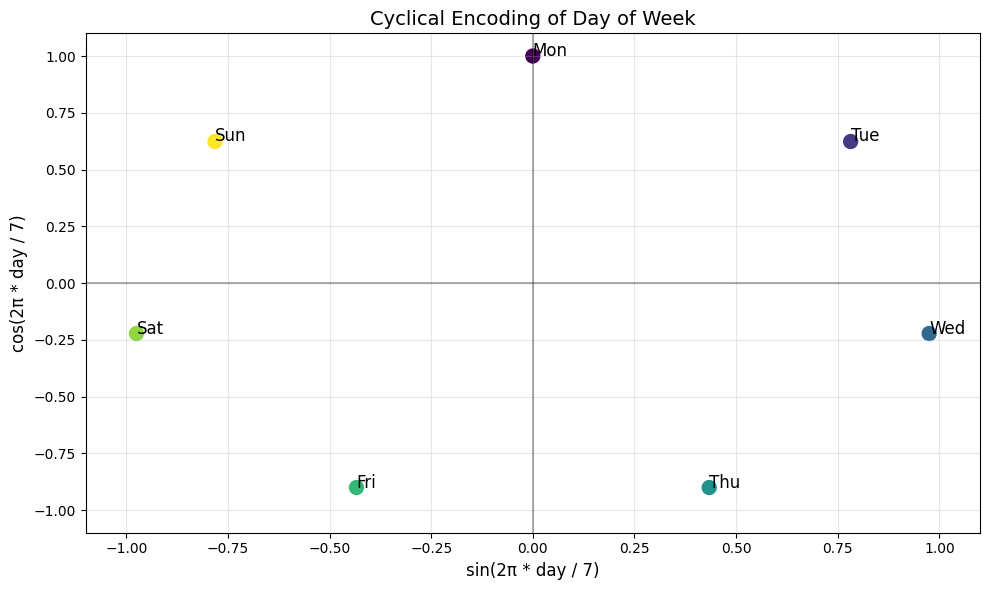

In [96]:

#  visualization to demonstrate the cyclical encoding

fig, ax = plt.subplots(figsize=(10, 6))
days = list(range(7))
sin_values = [np.sin(2 * np.pi * day / 7) for day in days]
cos_values = [np.cos(2 * np.pi * day / 7) for day in days]

ax.scatter(sin_values, cos_values, s=100, c=days, cmap='viridis')
for i, day_name in enumerate(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']):
    ax.annotate(day_name, (sin_values[i], cos_values[i]), fontsize=12)
    
ax.set_xlim(-1.1, 1.1)
ax.set_ylim(-1.1, 1.1)
ax.axhline(y=0, color='k', linestyle='-', alpha=0.3)
ax.axvline(x=0, color='k', linestyle='-', alpha=0.3)
ax.set_title('Cyclical Encoding of Day of Week', fontsize=14)
ax.set_xlabel('sin(2π * day / 7)', fontsize=12)
ax.set_ylabel('cos(2π * day / 7)', fontsize=12)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [97]:
# <Student to fill this section>
data_cleaning_2_explanations = """
Provide some explanations on why you believe it is important to fix this issue and its impacts

Importance:

Days of the week are cyclical (e.g., Monday follows Sunday), so using raw integer encoding can mislead models about their relationships.
Sine and cosine transformations preserve cyclical patterns, allowing models to recognize that the start and end of the week are adjacent.
Proper encoding helps capture weekly seasonality and trading patterns in financial time series.

Impacts:

Improves model accuracy by correctly representing temporal relationships.
Enables detection of day-specific effects (e.g., weekend vs. weekday trends) in price movements.
Reduces risk of spurious patterns and enhances generalization to new data.
Supports more robust feature engineering for time-based predictions.

"""

In [98]:
# Do not modify this code
print_tile(size="h3", key='data_cleaning_2_explanations', value=data_cleaning_2_explanations)

### F.3 Data Transformation Normalization

In [99]:
# <Student to fill this section>

In [100]:
# Feature Normalization Pipeline
def normalize_features(df):
    """Normalize selected features but keep the original DataFrame structure"""
    result_df = df.copy()
    
    # Features to normalize (numerical features with different scales)
    features_to_normalize = [
        # Price-related features
        'open_log', 'low_log', 'close_log', 'ema_12d_log',
        
        # Volume and market metrics with large scales
        'volume_log', 'marketCap_log', 
        
        # Derived features that need normalization
        'circulatingSupply', 'velocity_log'
    ]
    
    # Filter to only include columns that exist in the dataframe
    features_to_normalize = [col for col in features_to_normalize if col in df.columns]
    
    if features_to_normalize:  # Only proceed if there are columns to scale
        # Create a scaler and fit it to the selected columns
        scaler = StandardScaler()
        result_df[features_to_normalize] = scaler.fit_transform(df[features_to_normalize])
    
    return result_df, features_to_normalize

# Apply normalization
df_normalized, normalized_features = normalize_features(df)

print("Normalized features:", normalized_features)
print("Sample of normalized data:")
print(df_normalized[normalized_features].describe())

# If you need the target variable statistics
if 'target_next_day_high' in df_normalized.columns:
    print("\nTarget variable statistics:")
    print(df_normalized['target_next_day_high'].describe())

Normalized features: ['open_log', 'low_log', 'close_log', 'ema_12d_log', 'volume_log', 'marketCap_log', 'circulatingSupply', 'velocity_log']
Sample of normalized data:
           open_log       low_log     close_log   ema_12d_log    volume_log  \
count  3.652000e+03  3.652000e+03  3.652000e+03  3.652000e+03  3.652000e+03   
mean   6.848605e-16 -2.490402e-16  3.735603e-16 -1.867801e-16 -5.603404e-16   
std    1.000137e+00  1.000137e+00  1.000137e+00  1.000137e+00  1.000137e+00   
min   -2.087312e+00 -2.095125e+00 -2.084631e+00 -1.951895e+00 -2.444362e+00   
25%   -5.876575e-01 -5.905464e-01 -5.864651e-01 -5.875638e-01 -5.160360e-01   
50%    1.537720e-01  1.545467e-01  1.530149e-01  1.516004e-01  4.737407e-01   
75%    8.276859e-01  8.171361e-01  8.271364e-01  8.384750e-01  7.306448e-01   
max    1.498013e+00  1.508275e+00  1.497338e+00  1.477003e+00  1.674136e+00   

       marketCap_log  circulatingSupply  velocity_log  
count   3.652000e+03       3.652000e+03  3.652000e+03  
mean    

In [101]:
df=df_normalized.copy() # Update df to include transformed features

Update the features list

In [102]:
features_list=['circulatingSupply', 'open_log', 'high_log', 'low_log', 'close_log',
       'volume_log', 'marketCap_log', 'velocity_log', 'ema_12d_log','target_next_day_high','day_of_week_sin', 'day_of_week_cos']

In [103]:
# <Student to fill this section>
data_cleaning_3_explanations = """
Provide some explanations on why you believe it is important to fix this issue and its impacts

Importance:

Normalization scales features to a common range, preventing features with larger values from dominating model training.
Many machine learning algorithms (e.g., linear regression, neural networks) assume features are on similar scales for optimal performance.
It helps improve convergence speed and stability during training.

Impacts:

Enhances model accuracy and reliability by ensuring all features contribute equally.
Reduces risk of numerical instability and improves interpretability of model coefficients.
Facilitates fair comparison between features and supports better feature selection.
Normalized data is especially important when combining features with different units or magnitudes.
"""

In [104]:
# Do not modify this code
print_tile(size="h3", key='data_cleaning_3_explanations', value=data_cleaning_3_explanations)

---
## G. Data Preparation for Modeling

### G.1 Split Datasets

In [105]:
# <Student to fill this section>

In [106]:
# Time-Series Data Split for Bitcoin Price Forecasting


# Define function for time-based splitting (proper approach for time series)
def time_series_split(df, target_col, test_size=0.15, val_size=0.15):
    """
    Splits time series data into train, validation, and test sets based on chronological ordering.
    
    Parameters:
    -----------
    df : pandas DataFrame
        The dataframe sorted by date/time
    target_col : str
        Name of the target column
    test_size : float
        Proportion of data to use for testing (most recent data)
    val_size : float
        Proportion of data to use for validation (second most recent portion)
        
    Returns:
    --------
    X_train, X_val, X_test, y_train, y_val, y_test : DataFrames for model training and evaluation
    """
    # Verify the dataframe is sorted by time
    if 'timeOpen' in df.columns:
        df = df.sort_values('timeOpen').reset_index(drop=True)
    
    # Calculate split indices
    n = len(df)
    test_idx = int(n * (1 - test_size))
    val_idx = int(n * (1 - test_size - val_size))
    
    # Split the data
    train_df = df.iloc[:val_idx].copy()
    val_df = df.iloc[val_idx:test_idx].copy()
    test_df = df.iloc[test_idx:].copy()
    
    print(f"Training data: {len(train_df)} rows ({train_df['timeOpen'].min()} to {train_df['timeOpen'].max()})")
    print(f"Validation data: {len(val_df)} rows ({val_df['timeOpen'].min()} to {val_df['timeOpen'].max()})")
    print(f"Test data: {len(test_df)} rows ({test_df['timeOpen'].min()} to {test_df['timeOpen'].max()})")
    
    # Separate features and target
    X_train = train_df.drop(columns=[target_col])
    y_train = train_df[target_col]
    
    X_val = val_df.drop(columns=[target_col])
    y_val = val_df[target_col]
    
    X_test = test_df.drop(columns=[target_col])
    y_test = test_df[target_col]
    
    return X_train, X_val, X_test, y_train, y_val, y_test


In [107]:

# Function to prepare dataframe for modeling by removing non-feature columns
def prepare_for_modeling(X_train, X_val, X_test):
    """Remove columns that shouldn't be used as features in the model"""
    # Identify columns to drop (time columns, string columns, etc.)
    cols_to_drop = ['timeOpen', 'timeClose', 'timeHigh', 'timeLow', 'name', 'timestamp']
    
    # Only drop columns that actually exist in the dataframes
    cols_to_drop = [col for col in cols_to_drop if col in X_train.columns]
    
    # Drop the columns
    X_train_model = X_train.drop(columns=cols_to_drop, errors='ignore')
    X_val_model = X_val.drop(columns=cols_to_drop, errors='ignore')
    X_test_model = X_test.drop(columns=cols_to_drop, errors='ignore')
    
    return X_train_model, X_val_model, X_test_model

# Apply the splitting
target_name = 'target_next_day_high'
X_train, X_val, X_test, y_train, y_val, y_test = time_series_split(df, target_name)

# Prepare data for modeling (remove datetime columns, etc.)
X_train_model, X_val_model, X_test_model = prepare_for_modeling(X_train, X_val, X_test)


Training data: 2556 rows (2015-01-01 00:00:00+00:00 to 2021-12-30 00:00:00+00:00)
Validation data: 548 rows (2021-12-31 00:00:00+00:00 to 2023-07-01 00:00:00+00:00)
Test data: 548 rows (2023-07-02 00:00:00+00:00 to 2024-12-30 00:00:00+00:00)


In [108]:

# Verify dimensions of the resulting datasets
print("\nFeature dimensions:")
print(f"X_train: {X_train_model.shape}")
print(f"X_val: {X_val_model.shape}")
print(f"X_test: {X_test_model.shape}")

print("\nTarget dimensions:")
print(f"y_train: {y_train.shape}")
print(f"y_val: {y_val.shape}")
print(f"y_test: {y_test.shape}")

# Verify feature consistency
print("\nFeatures included in model data:")
print(X_train_model.columns.tolist())

# Optional: Check for missing values in the prepared datasets
print("\nMissing values in training features:", X_train_model.isnull().sum().sum())
print("Missing values in validation features:", X_val_model.isnull().sum().sum())
print("Missing values in test features:", X_test_model.isnull().sum().sum())

# For saving in subsequent code, update variables to use the model-ready dataframes
X_train = X_train_model
X_val = X_val_model
X_test = X_test_model


Feature dimensions:
X_train: (2556, 11)
X_val: (548, 11)
X_test: (548, 11)

Target dimensions:
y_train: (2556,)
y_val: (548,)
y_test: (548,)

Features included in model data:
['circulatingSupply', 'open_log', 'high_log', 'low_log', 'close_log', 'volume_log', 'marketCap_log', 'velocity_log', 'ema_12d_log', 'day_of_week_sin', 'day_of_week_cos']

Missing values in training features: 0
Missing values in validation features: 0
Missing values in test features: 0


In [109]:
# <Student to fill this section>
data_splitting_explanations = """
Provide some explanations on what is the best strategy to use for data splitting for this dataset


Importance of Temporal Order:

Time series data must be split chronologically to prevent data leakage and ensure realistic model evaluation.
Training, validation, and test sets should follow the natural sequence of dates.
Recommended Strategy:

Use a forward-chaining split: train on earlier data, validate on a subsequent period, and test on the most recent period.
Avoid random shuffling, as it can mix future information into the past and distort results.
Impacts:

Preserves the integrity of temporal dependencies and trends.
Ensures the model is evaluated on unseen, future data, simulating real-world forecasting.
Supports robust hyperparameter tuning and unbiased performance assessment.


"""

In [110]:
# Do not modify this code
print_tile(size="h3", key='data_splitting_explanations', value=data_splitting_explanations)

---
## H. Save Datasets

> Do not change this code

In [111]:
# Do not modify this code
# Save training set
try:
  X_train.to_csv(at.folder_path / 'X_train.csv', index=False)
  y_train.to_csv(at.folder_path / 'y_train.csv', index=False)

  X_val.to_csv(at.folder_path / 'X_val.csv', index=False)
  y_val.to_csv(at.folder_path / 'y_val.csv', index=False)

  X_test.to_csv(at.folder_path / 'X_test.csv', index=False)
  y_test.to_csv(at.folder_path / 'y_test.csv', index=False)
except Exception as e:
  print(e)

name 'at' is not defined


---
## I. Selection of Performance Metrics

> Provide some explanations on why you believe the performance metrics you chose is appropriate


In [112]:
# <Student to fill this section>

In [113]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [114]:
# <Student to fill this section>
performance_metrics_explanations = """
Provide some explanations on why you believe the performance metrics you chose is appropriate

R² (Coefficient of Determination):

Measures the proportion of variance in the target variable explained by the model.
Indicates overall goodness-of-fit; higher values mean better predictive power.
Useful for comparing models and understanding how well features capture target variability.

RMSE (Root Mean Squared Error):

Quantifies the average magnitude of prediction errors in the same units as the target.
Sensitive to large errors, making it effective for highlighting poor predictions.
Easy to interpret and compare across models and datasets.

Why Appropriate:

Both metrics are standard for regression problems, providing complementary insights: R² for explanatory power, RMSE for error magnitude.
They help assess model accuracy and reliability, supporting informed model selection and improvement

"""

In [115]:
# Do not modify this code
print_tile(size="h3", key='performance_metrics_explanations', value=performance_metrics_explanations)

## J. Train Machine Learning Model

### J.0 Import Dummy Regressor as baseline model 

> Provide some explanations on why you believe this algorithm is a good fit


In [116]:
# Import, train, and predict with DummyRegressor
from sklearn.dummy import DummyRegressor

# Fit DummyRegressor on training data
dummy = DummyRegressor(strategy='mean')
dummy.fit(X_train, y_train)

# Predict on validation and test sets
y_val_pred = dummy.predict(X_val)
y_val_pred[:5]

array([11486.07009848, 11486.07009848, 11486.07009848, 11486.07009848,
       11486.07009848])

In [117]:
y_test_pred = dummy.predict(X_test)
# Calculate metrics for validation set
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
val_r2 = r2_score(y_val, y_val_pred)

# Calculate metrics for test set
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_r2 = r2_score(y_test, y_test_pred)

# Print results
print("DummyRegressor Performance:")
print("-" * 40)
print(f"Validation RMSE: ${val_rmse:.2f}")
print(f"Validation R²:   {val_r2:.4f}")
print("-" * 40)
print(f"Test RMSE:       ${test_rmse:.2f}")
print(f"Test R²:         {test_r2:.4f}")

DummyRegressor Performance:
----------------------------------------
Validation RMSE: $18612.86
Validation R²:   -3.4070
----------------------------------------
Test RMSE:       $48810.87
Test R²:         -4.5880


In [118]:
from doombuoy import regression_model_comparison_summary, regression_model_comparison_models

# Prepare your DataFrame `df` with features and a numeric target column, e.g., 'target'
summary = regression_model_comparison_summary(df[features_list], target_col=target_name)
print(summary.sort_values(by='RMSE', ascending=True))

# To see model abbreviations and their full names:
regression_model_comparison_models()

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000171 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2309
[LightGBM] [Info] Number of data points in the train set: 2739, number of used features: 11
[LightGBM] [Info] Start training from score 20691.637482
              Model         MAE        RMSE      R2 RMSLE     MAPE  TT (Sec)
17               et    368.0846    723.6392  0.9990  None   0.0185      1.06
9              gbrt    383.9646    743.1838  0.9989  None   0.0376      1.36
10               rf    387.6898    783.3928  0.9988  None   0.0192      2.64
14         lightgbm    398.1768    863.8558  0.9986  None   0.0257      0.20
11         catboost    444.3801    868.6562  0.9986  None   0.0457      3.73
16               dt    506.2449   1033.9640  0.9980  None   0.0250      0.04
13              knn    700.0957   1469.5152  0.9959  None   0.0377      0.00
15              ada   1473.0317   1827.

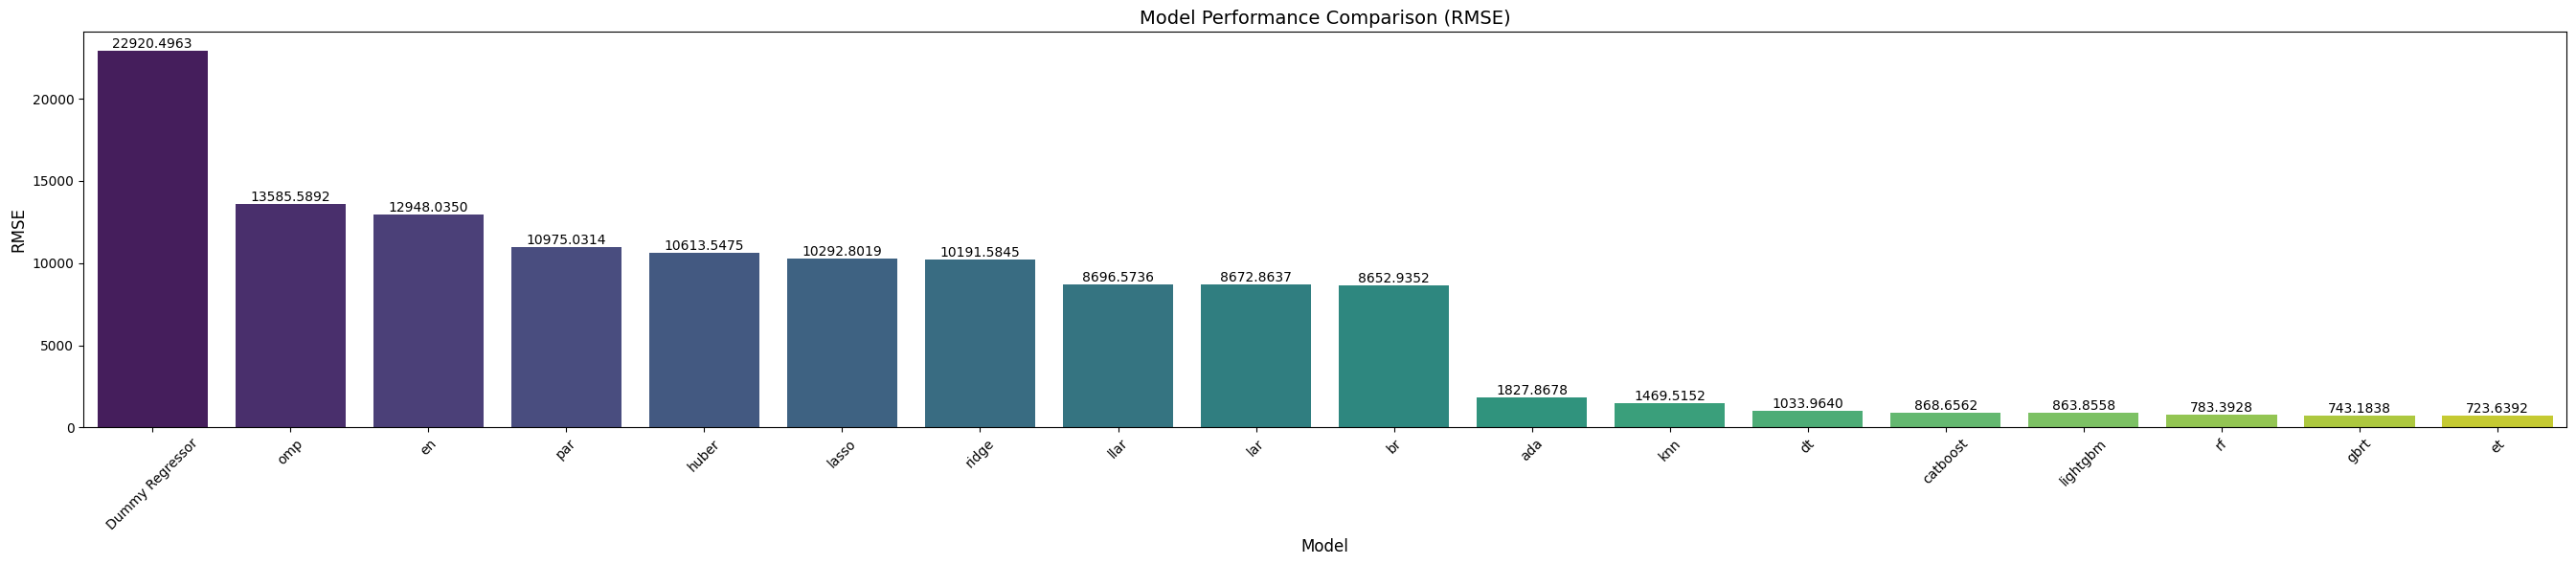

In [119]:
from doombuoy import plot_model_performance as pmp
pmp(summary, metric='RMSE')

### J.1.A. Import Algorithm

> Provide some explanations on why you believe this algorithm is a good fit


In [120]:
# <Student to fill this section>

In [121]:
from sklearn.ensemble import ExtraTreesRegressor

In [122]:
# <Student to fill this section>
algorithm_selection_explanations = """
Provide some explanations on why you believe this algorithm is a good fit

Performance:

It achieves the lowest RMSE and highest R² among tested models, indicating excellent predictive accuracy and fit.
Handles large feature sets and complex relationships effectively.

Algorithm Strengths:

Robust to outliers and noise due to ensemble averaging.
Captures non-linear patterns and feature interactions, which are common in financial time series.
Less prone to overfitting compared to single decision trees.

Practical Benefits:

Fast training and prediction times, suitable for large datasets.
Provides feature importance scores, aiding interpretability and further feature selection.
"""

In [123]:
# Do not modify this code
print_tile(size="h3", key='algorithm_selection_explanations', value=algorithm_selection_explanations)

### J.1.B. Import Algorithm

> Provide some explanations on why you believe this algorithm is a good fit


In [124]:
from sklearn.ensemble import GradientBoostingRegressor

In [125]:
# <Student to fill this section>
algorithm_selection_explanations = """
Provide some explanations on why you believe this algorithm is a good fit

Performance:

It achieves the second lowest RMSE and second highest R² among tested models, indicating excellent predictive accuracy and fit.
Handles large feature sets and complex relationships effectively.

Algorithm Strengths:

Robust to outliers and noise due to sequential boosting and ensemble averaging.
Captures non-linear patterns and feature interactions, which are common in financial time series.
Uses gradient boosting to iteratively improve predictions, reducing bias and variance.

Practical Benefits:

Provides feature importance scores, aiding interpretability and further feature selection.
Flexible with hyperparameters for fine-tuning to prevent overfitting.
Suitable for regression tasks with continuous targets like price prediction.
"""


In [126]:
# Do not modify this code
print_tile(size="h3", key='algorithm_selection_explanations', value=algorithm_selection_explanations)

### J.2.A. Set Hyperparameters (Extra Tree)

> Provide some explanations on why you believe this algorithm is a good fit


Best n_estimators: 100
Best max_depth: 10
Best min_samples_split: 2
Best min_samples_leaf: 1
Best bootstrap: False


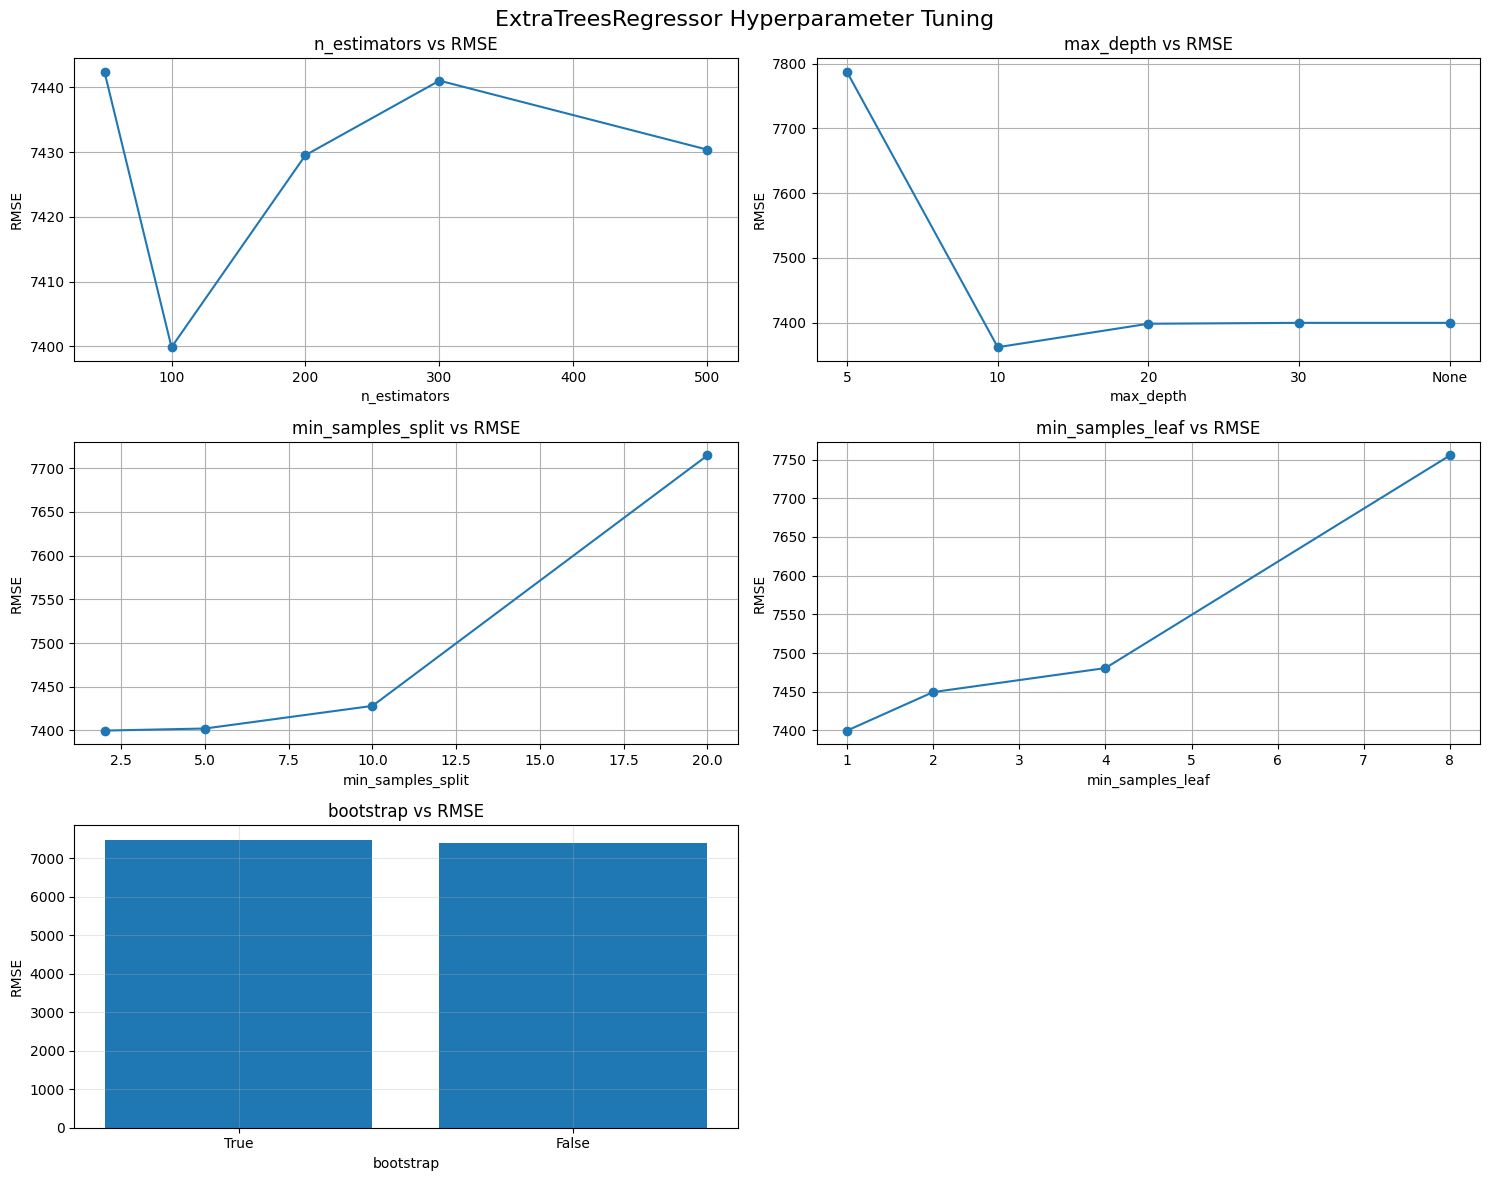

In [127]:


# RMSE scorer
rmse_scorer = make_scorer(mean_squared_error, squared=False, greater_is_better=False)

# Create subplots grid (3 rows, 2 columns)
fig, axes = plt.subplots(3, 2, figsize=(15, 12))
fig.suptitle('ExtraTreesRegressor Hyperparameter Tuning', fontsize=16)

# 1. n_estimators
n_estimators_values = [50, 100, 200, 300, 500]
scores = []
for n_est in n_estimators_values:
    model = ExtraTreesRegressor(n_estimators=n_est, random_state=42, n_jobs=-1)
    cv_scores = cross_val_score(model, X_train, y_train, cv=3, scoring=rmse_scorer)
    scores.append(-np.mean(cv_scores))

axes[0, 0].plot(n_estimators_values, scores, marker='o')
axes[0, 0].set_title("n_estimators vs RMSE")
axes[0, 0].set_xlabel("n_estimators")
axes[0, 0].set_ylabel("RMSE")
axes[0, 0].grid(True)
print(f"Best n_estimators: {n_estimators_values[np.argmin(scores)]}")

# 2. max_depth
max_depth_values = [5, 10, 20, 30, None]
scores = []
for depth in max_depth_values:
    model = ExtraTreesRegressor(n_estimators=100, max_depth=depth, random_state=42, n_jobs=-1)
    cv_scores = cross_val_score(model, X_train, y_train, cv=3, scoring=rmse_scorer)
    scores.append(-np.mean(cv_scores))

axes[0, 1].plot([str(d) for d in max_depth_values], scores, marker='o')
axes[0, 1].set_title("max_depth vs RMSE")
axes[0, 1].set_xlabel("max_depth")
axes[0, 1].set_ylabel("RMSE")
axes[0, 1].grid(True)
print(f"Best max_depth: {max_depth_values[np.argmin(scores)]}")

# 3. min_samples_split
min_samples_split_values = [2, 5, 10, 20]
scores = []
for split in min_samples_split_values:
    model = ExtraTreesRegressor(n_estimators=100, min_samples_split=split, random_state=42, n_jobs=-1)
    cv_scores = cross_val_score(model, X_train, y_train, cv=3, scoring=rmse_scorer)
    scores.append(-np.mean(cv_scores))

axes[1, 0].plot(min_samples_split_values, scores, marker='o')
axes[1, 0].set_title("min_samples_split vs RMSE")
axes[1, 0].set_xlabel("min_samples_split")
axes[1, 0].set_ylabel("RMSE")
axes[1, 0].grid(True)
print(f"Best min_samples_split: {min_samples_split_values[np.argmin(scores)]}")

# 4. min_samples_leaf
min_samples_leaf_values = [1, 2, 4, 8]
scores = []
for leaf in min_samples_leaf_values:
    model = ExtraTreesRegressor(n_estimators=100, min_samples_leaf=leaf, random_state=42, n_jobs=-1)
    cv_scores = cross_val_score(model, X_train, y_train, cv=3, scoring=rmse_scorer)
    scores.append(-np.mean(cv_scores))

axes[1, 1].plot(min_samples_leaf_values, scores, marker='o')
axes[1, 1].set_title("min_samples_leaf vs RMSE")
axes[1, 1].set_xlabel("min_samples_leaf")
axes[1, 1].set_ylabel("RMSE")
axes[1, 1].grid(True)
print(f"Best min_samples_leaf: {min_samples_leaf_values[np.argmin(scores)]}")

# 5. bootstrap
bootstrap_values = [True, False]
scores = []
for boot in bootstrap_values:
    model = ExtraTreesRegressor(n_estimators=100, bootstrap=boot, random_state=42, n_jobs=-1)
    cv_scores = cross_val_score(model, X_train, y_train, cv=3, scoring=rmse_scorer)
    scores.append(-np.mean(cv_scores))

axes[2, 0].bar(['True', 'False'], scores)
axes[2, 0].set_title("bootstrap vs RMSE")
axes[2, 0].set_xlabel("bootstrap")
axes[2, 0].set_ylabel("RMSE")
axes[2, 0].grid(True, alpha=0.3)
print(f"Best bootstrap: {bootstrap_values[np.argmin(scores)]}")

# Hide the empty subplot
axes[2, 1].axis('off')

plt.tight_layout()
plt.show()

In [128]:
# Define parameter grid for ExtraTreesRegressor
param_grid = {
    'n_estimators':[200,500,600,700,800,900,1000],
    'max_depth': [10,15,20,25],
    'min_samples_split':[2,3,4,5],
    'min_samples_leaf': [1,2,3,4],
    'bootstrap': [True, False]
}

In [129]:
# <Student to fill this section>
hyperparameters_selection_explanations = """
Explain why you are tuning these hyperparameters
Extra Trees Regressor hyperparameters are tuned:

- n_estimators: Controls the number of trees in the ensemble. Tuning helps balance model accuracy and computational efficiency.
- max_depth: Limits the depth of each tree. Adjusting it prevents overfitting and improves generalization.
- min_samples_split: Sets the minimum samples required to split a node. Tuning helps control tree complexity and avoid overfitting.
- min_samples_leaf: Specifies the minimum samples at a leaf node. Proper tuning ensures leaves are not too small, improving model stability.
- bootstrap: Determines whether sampling is with or without replacement. Tuning this can affect variance and bias, impacting model robustness.

Tuning these parameters optimizes model performance, reduces overfitting, and ensures the best predictive results for your dataset.

"""


In [130]:
# Do not modify this code
print_tile(size="h3", key='hyperparameters_selection_explanations', value=hyperparameters_selection_explanations)

### J.2.B. Set Hyperparameters (GBRT)

> Provide some explanations on why you believe this algorithm is a good fit


Best n_estimators: 500
Best max_depth: 10
Best learning_rate: 0.2
Best min_samples_split: 20
Best min_samples_leaf: 2
Best subsample: 1.0


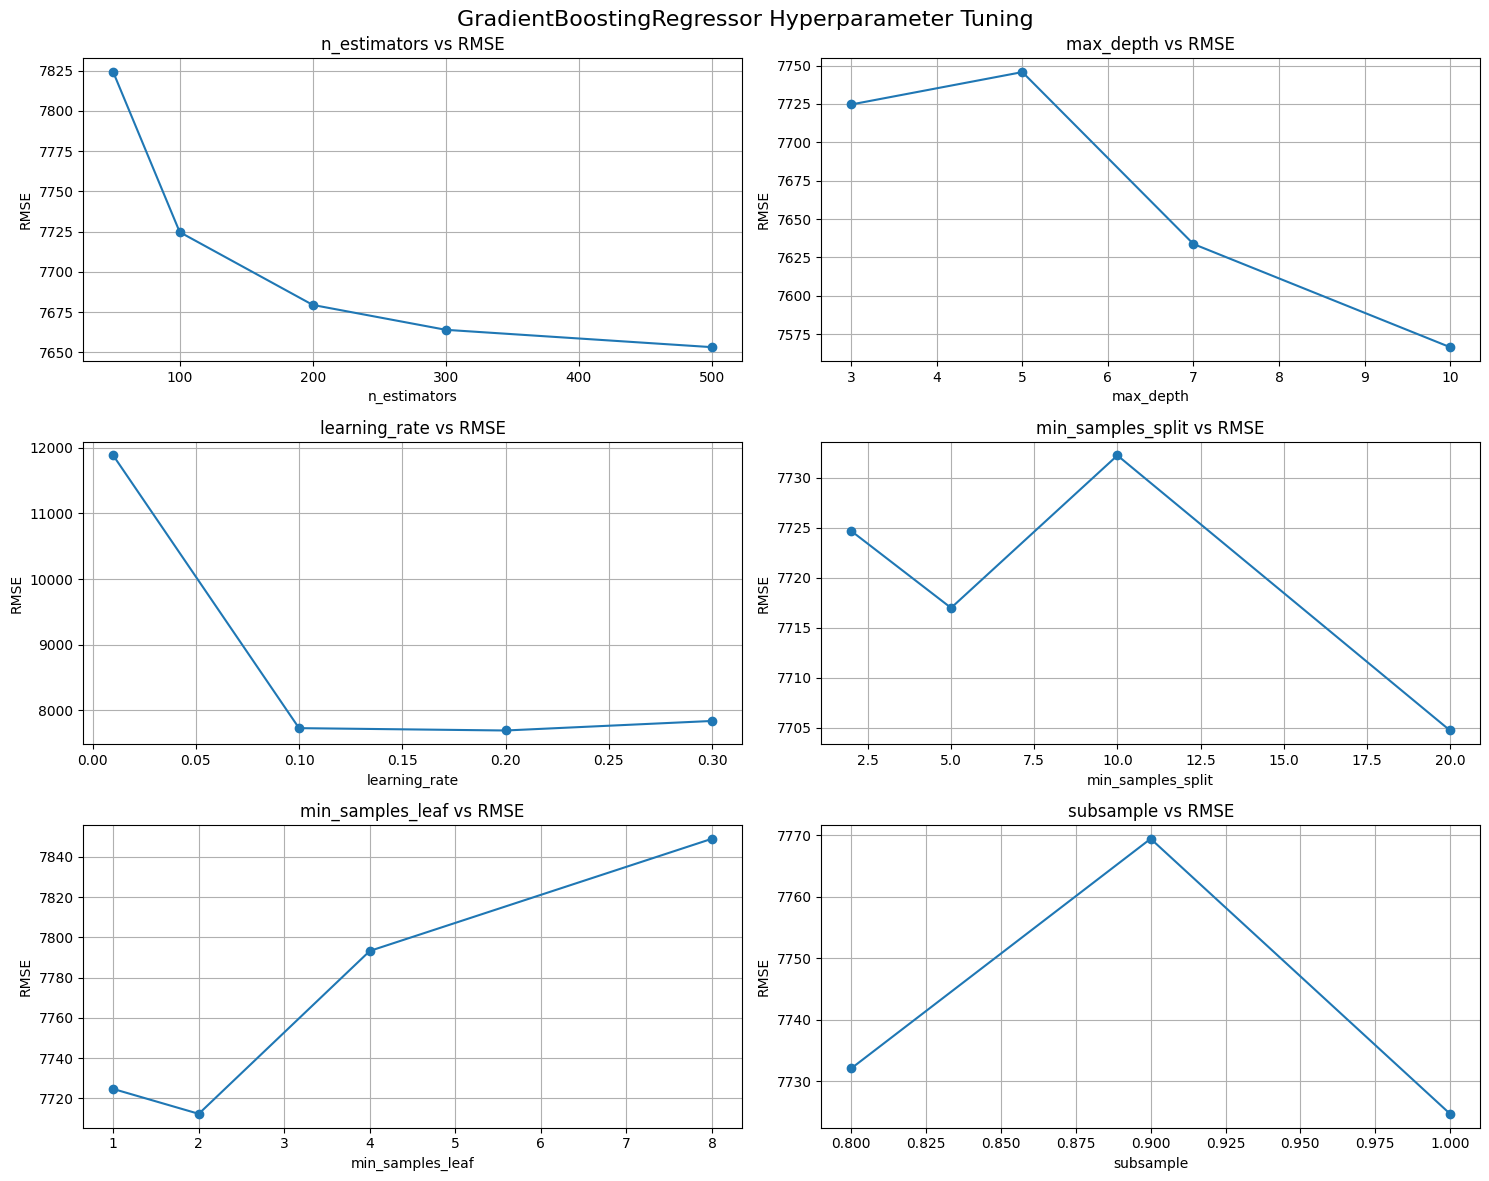

In [131]:
# RMSE scorer
rmse_scorer = make_scorer(mean_squared_error, squared=False, greater_is_better=False)

# Create subplots grid (3 rows, 2 columns)
fig, axes = plt.subplots(3, 2, figsize=(15, 12))
fig.suptitle('GradientBoostingRegressor Hyperparameter Tuning', fontsize=16)

# 1. n_estimators
n_estimators_values = [50, 100, 200, 300, 500]
scores = []
for n_est in n_estimators_values:
    model = GradientBoostingRegressor(n_estimators=n_est, random_state=42)
    cv_scores = cross_val_score(model, X_train, y_train, cv=3, scoring=rmse_scorer)
    scores.append(-np.mean(cv_scores))

axes[0, 0].plot(n_estimators_values, scores, marker='o')
axes[0, 0].set_title("n_estimators vs RMSE")
axes[0, 0].set_xlabel("n_estimators")
axes[0, 0].set_ylabel("RMSE")
axes[0, 0].grid(True)
print(f"Best n_estimators: {n_estimators_values[np.argmin(scores)]}")

# 2. max_depth
max_depth_values = [3, 5, 7, 10]
scores = []
for depth in max_depth_values:
    model = GradientBoostingRegressor(n_estimators=100, max_depth=depth, random_state=42)
    cv_scores = cross_val_score(model, X_train, y_train, cv=3, scoring=rmse_scorer)
    scores.append(-np.mean(cv_scores))

axes[0, 1].plot(max_depth_values, scores, marker='o')
axes[0, 1].set_title("max_depth vs RMSE")
axes[0, 1].set_xlabel("max_depth")
axes[0, 1].set_ylabel("RMSE")
axes[0, 1].grid(True)
print(f"Best max_depth: {max_depth_values[np.argmin(scores)]}")

# 3. learning_rate
learning_rate_values = [0.01, 0.1, 0.2, 0.3]
scores = []
for lr in learning_rate_values:
    model = GradientBoostingRegressor(n_estimators=100, learning_rate=lr, random_state=42)
    cv_scores = cross_val_score(model, X_train, y_train, cv=3, scoring=rmse_scorer)
    scores.append(-np.mean(cv_scores))

axes[1, 0].plot(learning_rate_values, scores, marker='o')
axes[1, 0].set_title("learning_rate vs RMSE")
axes[1, 0].set_xlabel("learning_rate")
axes[1, 0].set_ylabel("RMSE")
axes[1, 0].grid(True)
print(f"Best learning_rate: {learning_rate_values[np.argmin(scores)]}")

# 4. min_samples_split
min_samples_split_values = [2, 5, 10, 20]
scores = []
for split in min_samples_split_values:
    model = GradientBoostingRegressor(n_estimators=100, min_samples_split=split, random_state=42)
    cv_scores = cross_val_score(model, X_train, y_train, cv=3, scoring=rmse_scorer)
    scores.append(-np.mean(cv_scores))

axes[1, 1].plot(min_samples_split_values, scores, marker='o')
axes[1, 1].set_title("min_samples_split vs RMSE")
axes[1, 1].set_xlabel("min_samples_split")
axes[1, 1].set_ylabel("RMSE")
axes[1, 1].grid(True)
print(f"Best min_samples_split: {min_samples_split_values[np.argmin(scores)]}")

# 5. min_samples_leaf
min_samples_leaf_values = [1, 2, 4, 8]
scores = []
for leaf in min_samples_leaf_values:
    model = GradientBoostingRegressor(n_estimators=100, min_samples_leaf=leaf, random_state=42)
    cv_scores = cross_val_score(model, X_train, y_train, cv=3, scoring=rmse_scorer)
    scores.append(-np.mean(cv_scores))

axes[2, 0].plot(min_samples_leaf_values, scores, marker='o')
axes[2, 0].set_title("min_samples_leaf vs RMSE")
axes[2, 0].set_xlabel("min_samples_leaf")
axes[2, 0].set_ylabel("RMSE")
axes[2, 0].grid(True)
print(f"Best min_samples_leaf: {min_samples_leaf_values[np.argmin(scores)]}")

# 6. subsample 
subsample_values = [0.8, 0.9, 1.0]
scores = []
for sub in subsample_values:
    model = GradientBoostingRegressor(n_estimators=100, subsample=sub, random_state=42)
    cv_scores = cross_val_score(model, X_train, y_train, cv=3, scoring=rmse_scorer)
    scores.append(-np.mean(cv_scores))

axes[2, 1].plot(subsample_values, scores, marker='o')
axes[2, 1].set_title("subsample vs RMSE")
axes[2, 1].set_xlabel("subsample")
axes[2, 1].set_ylabel("RMSE")
axes[2, 1].grid(True)
print(f"Best subsample: {subsample_values[np.argmin(scores)]}")

plt.tight_layout()
plt.show()

In [132]:
# Define parameter grid for GradientBoostingRegressor
gbrt_param_grid = {
    'n_estimators':[500,600,700],
    'max_depth': [10,15,20],
    'min_samples_split':[5,20,25,30],
    'min_samples_leaf': [1,2,3],
    'learning_rate': [ 0.19,0.2,0.21],
    'subsample': [0.7,0.8,1.0]
}

In [133]:
# <Student to fill this section>
hyperparameters_selection_explanations = """
Explain why you are tuning these hyperparameters
GradientBoostingRegressor hyperparameters are tuned:

- n_estimators: Controls the number of boosting stages (trees). Tuning helps balance model accuracy and computational efficiency, as more trees can improve performance but increase training time.
- max_depth: Limits the depth of each individual tree. Adjusting it prevents overfitting by controlling tree complexity and improves generalization on unseen data.
- min_samples_split: Sets the minimum number of samples required to split an internal node. Tuning helps control tree complexity and avoid overfitting by ensuring splits are based on sufficient data.
- min_samples_leaf: Specifies the minimum number of samples required at a leaf node. Proper tuning ensures leaves are not too small, improving model stability and reducing variance.
- learning_rate: Determines the contribution of each tree to the final prediction. Tuning this balances bias and variance, with lower rates often requiring more trees for better generalization.
- subsample: Fraction of samples used for fitting each tree. Values less than 1.0 introduce randomness, which can reduce overfitting and improve robustness.

Tuning these parameters optimizes model performance, reduces overfitting, and ensures the best predictive results for your dataset.

"""


In [134]:
# Do not modify this code
print_tile(size="h3", key='hyperparameters_selection_explanations', value=hyperparameters_selection_explanations)

### J.3.A. Fit Model (Extra Tree)

In [135]:
# Create base model ExtraTreesRegressor
extra_trees_model = ExtraTreesRegressor(
    random_state=42,
    n_jobs=-1  # Use all available cores
)

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=extra_trees_model,
    param_grid=param_grid,
    cv=3,  # Time series data so keep CV small
    scoring='neg_root_mean_squared_error',
    verbose=2,
    n_jobs=-1  # Use all available cores
)

In [136]:
# Fit the grid search to find best parameters for ExtraTreesRegressor
print("Starting grid search for hyperparameter tuning...")
grid_search.fit(X_train, y_train)


Starting grid search for hyperparameter tuning...
Fitting 3 folds for each of 896 candidates, totalling 2688 fits


GridSearchCV(cv=3, estimator=ExtraTreesRegressor(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [10, 15, 20, 25],
                         'min_samples_leaf': [1, 2, 3, 4],
                         'min_samples_split': [2, 3, 4, 5],
                         'n_estimators': [200, 500, 600, 700, 800, 900, 1000]},
             scoring='neg_root_mean_squared_error', verbose=2)

In [137]:
# Print best parameters
print("\nBest parameters found:")
print(grid_search.best_params_)





Best parameters found:
{'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [138]:
# Train final model with best parameters for ExtraTreesRegressor
best_model = ExtraTreesRegressor(
    **grid_search.best_params_,
    random_state=42,
    n_jobs=-1
)

best_model.fit(X_train, y_train)

ExtraTreesRegressor(max_depth=10, n_estimators=200, n_jobs=-1, random_state=42)

### J.3.B. Fit Model (GBRT)

In [139]:
# Create base model GradientBoostingRegressor
gbrt_model = GradientBoostingRegressor(
    random_state=42
)

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=gbrt_model,
    param_grid=gbrt_param_grid,
    cv=3,  # Time series data so keep CV small
    scoring='neg_root_mean_squared_error',
    verbose=2,
    n_jobs=-1  # Use all available cores
)

In [140]:
# Fit the grid search to find best parameters for GradientBoostingRegressor
print("Starting grid search for hyperparameter tuning...")
grid_search.fit(X_train, y_train)

Starting grid search for hyperparameter tuning...
Fitting 3 folds for each of 972 candidates, totalling 2916 fits


GridSearchCV(cv=3, estimator=GradientBoostingRegressor(random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [0.19, 0.2, 0.21],
                         'max_depth': [10, 15, 20],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [5, 20, 25, 30],
                         'n_estimators': [500, 600, 700],
                         'subsample': [0.7, 0.8, 1.0]},
             scoring='neg_root_mean_squared_error', verbose=2)

In [141]:
# Print best parameters for GradientBoostingRegressor
print("\nBest parameters found:")
print(grid_search.best_params_)


Best parameters found:
{'learning_rate': 0.19, 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 500, 'subsample': 1.0}


In [142]:
# Train final model with best parameters for GradientBoostingRegressor (second best model)
second_best_model = GradientBoostingRegressor(
    **grid_search.best_params_,
    random_state=42
)

second_best_model.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.19, max_depth=20, min_samples_split=5,
                          n_estimators=500, random_state=42)

### J.4.A. Model Technical Performance (Extra Tree)

> Provide some explanations on model performance


In [143]:
# <Student to fill this section>

In [144]:

# Make predictions with tuned model
y_val_pred_tuned = best_model.predict(X_val)
y_test_pred_tuned = best_model.predict(X_test)
# Calculate metrics
val_rmse_tuned = np.sqrt(mean_squared_error(y_val, y_val_pred_tuned))
val_r2_tuned = r2_score(y_val, y_val_pred_tuned)
test_rmse_tuned = np.sqrt(mean_squared_error(y_test, y_test_pred_tuned))
test_r2_tuned = r2_score(y_test, y_test_pred_tuned)


In [145]:
# Print tuned model results
print("\nTuned ExtraTreesRegressor Model Performance:")
print("-" * 40)
print(f"Validation RMSE: ${val_rmse_tuned:.2f}")
print(f"Validation R²:   {val_r2_tuned:.4f}")
print("-" * 40)
print(f"Test RMSE:       ${test_rmse_tuned:.2f}")
print(f"Test R²:         {test_r2_tuned:.4f}")


Tuned ExtraTreesRegressor Model Performance:
----------------------------------------
Validation RMSE: $1700.10
Validation R²:   0.9632
----------------------------------------
Test RMSE:       $9312.73
Test R²:         0.7966


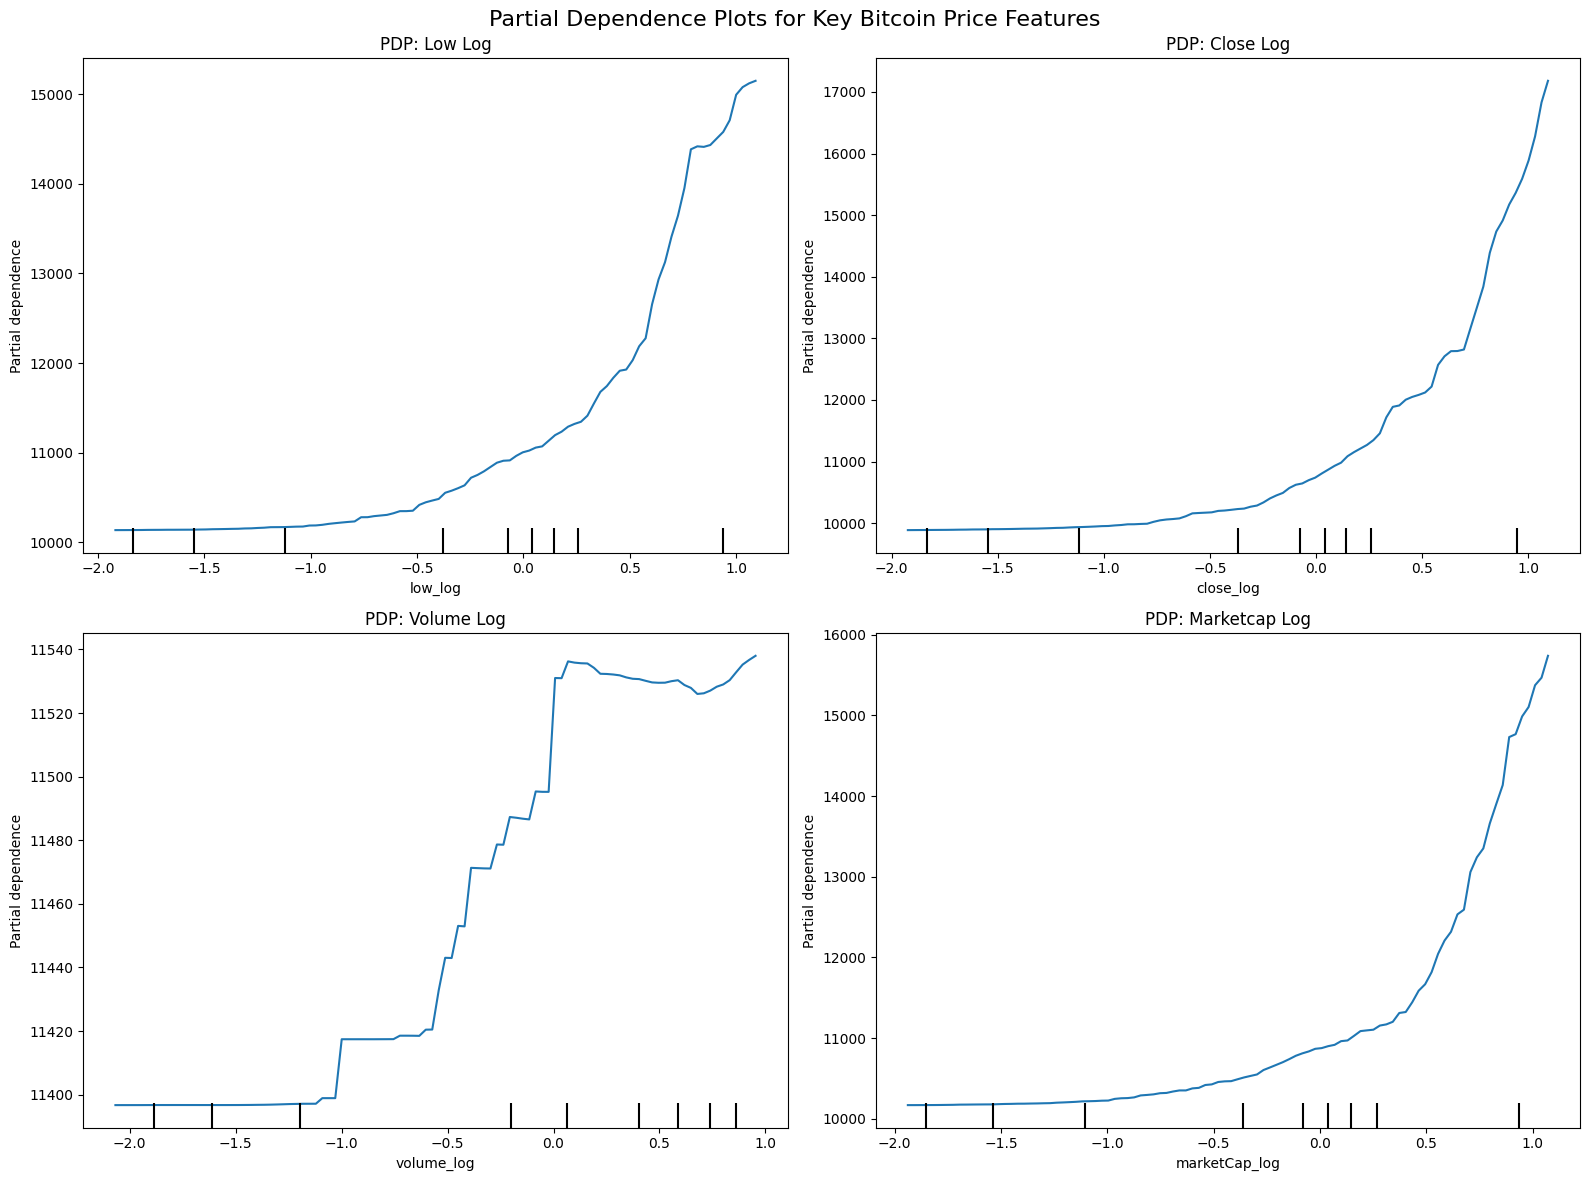

Feature Analysis Context:
low_log: Importance = 0.1479
close_log: Importance = 0.1489
volume_log: Importance = 0.0038
marketCap_log: Importance = 0.1345


In [146]:
# Create PDP for multiple key features including low_log
features_for_pdp = ['low_log', 'close_log', 'volume_log', 'marketCap_log']

# Filter features that exist in training data
available_features = [f for f in features_for_pdp if f in X_train.columns]

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.ravel()

for i, feature in enumerate(available_features[:4]):  # Limit to 4 features
    PartialDependenceDisplay.from_estimator(
        best_model, 
        X_train, 
        features=[feature],
        ax=axes[i]
    )
    axes[i].set_title(f'PDP: {feature.replace("_", " ").title()}')
    axes[i].grid(True, alpha=0.3)

plt.suptitle('Partial Dependence Plots for Key Bitcoin Price Features', fontsize=16)
plt.tight_layout()
plt.show()

# Print feature importance context
print("Feature Analysis Context:")
print("=" * 40)
for feature in available_features:
    if feature in X_train.columns:
        feature_importance = best_model.feature_importances_[list(X_train.columns).index(feature)]
        print(f"{feature}: Importance = {feature_importance:.4f}")

Generating learning curve for ExtraTreesRegressor...


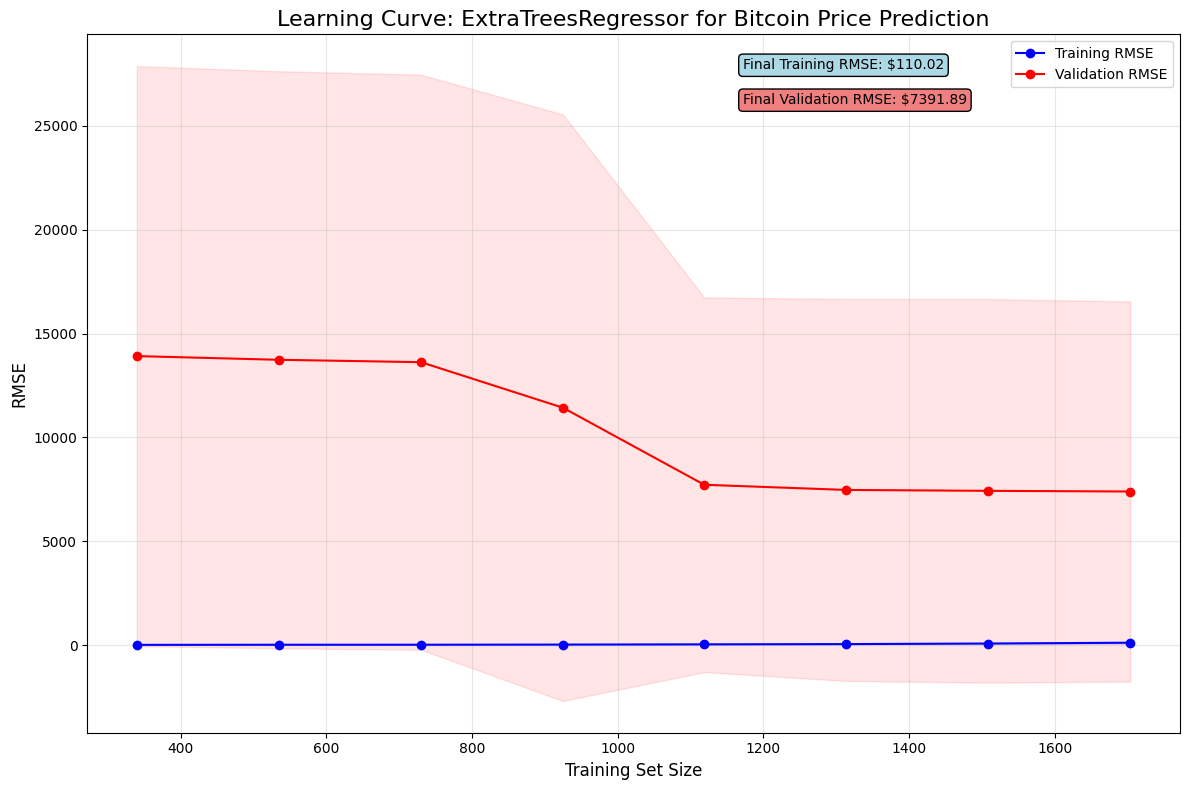

Learning Curve Analysis:
Training RMSE: $110.02 ± $46.79
Validation RMSE: $7391.89 ± $9153.34

Bias-Variance Analysis:
Training-Validation Gap: $7281.87
⚠️  High variance (overfitting) detected 


In [147]:


def plot_learning_curve(estimator, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)):
    """
    Plot learning curve to show training and validation scores vs training set size
    
    Parameters:
    -----------
    estimator : sklearn estimator
        The model to evaluate
    X : array-like
        Training features
    y : array-like
        Target values
    cv : int
        Number of cross-validation folds
    n_jobs : int
        Number of parallel jobs
    train_sizes : array-like
        Training set sizes to evaluate
    """
    
    # Generate learning curve data
    train_sizes, train_scores, val_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, 
        train_sizes=train_sizes, scoring='neg_root_mean_squared_error',
        random_state=42
    )
    
    # Convert negative RMSE to positive
    train_scores = -train_scores
    val_scores = -val_scores
    
    # Calculate mean and std
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)
    
    # Create the plot
    plt.figure(figsize=(12, 8))
    
    # Plot training scores
    plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training RMSE')
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, 
                     alpha=0.1, color='blue')
    
    # Plot validation scores
    plt.plot(train_sizes, val_mean, 'o-', color='red', label='Validation RMSE')
    plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, 
                     alpha=0.1, color='red')
    
    # Customize the plot
    plt.title('Learning Curve: ExtraTreesRegressor for Bitcoin Price Prediction', fontsize=16)
    plt.xlabel('Training Set Size', fontsize=12)
    plt.ylabel('RMSE', fontsize=12)
    plt.legend(loc='best')
    plt.grid(True, alpha=0.3)
    
    # Add annotations
    plt.text(0.6, 0.95, f'Final Training RMSE: ${train_mean[-1]:.2f}', 
             transform=plt.gca().transAxes, fontsize=10, 
             bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue"))
    plt.text(0.6, 0.90, f'Final Validation RMSE: ${val_mean[-1]:.2f}', 
             transform=plt.gca().transAxes, fontsize=10,
             bbox=dict(boxstyle="round,pad=0.3", facecolor="lightcoral"))
    
    plt.tight_layout()
    plt.show()
    
    # Print interpretation
    print("Learning Curve Analysis:")
    print("=" * 50)
    print(f"Training RMSE: ${train_mean[-1]:.2f} ± ${train_std[-1]:.2f}")
    print(f"Validation RMSE: ${val_mean[-1]:.2f} ± ${val_std[-1]:.2f}")
    
    # Analyze overfitting/underfitting
    gap = val_mean[-1] - train_mean[-1]
    print(f"\nBias-Variance Analysis:")
    print(f"Training-Validation Gap: ${gap:.2f}")
    
    if gap > 1000:  # Threshold for Bitcoin prices
        print("⚠️  High variance (overfitting) detected ")
    elif train_mean[-1] > 5000:  # Threshold for acceptable RMSE
        print("⚠️  High bias (underfitting) detected ")
    else:
        print("✅ Good bias-variance trade-off")
    
    return train_sizes, train_scores, val_scores

# Create learning curve for the best model
print("Generating learning curve for ExtraTreesRegressor...")
train_sizes, train_scores, val_scores = plot_learning_curve(
    estimator=best_model,
    X=X_train,
    y=y_train,
    cv=3,  # Use 3-fold CV for time series data
    train_sizes=np.linspace(0.2, 1.0, 8)  # Start from 20% to avoid too small samples
)

In [148]:
# <Student to fill this section>
model_performance_explanations = """
Provide some explanations on model performance

Learning Curve Analysis:

Training RMSE is very low, indicating the model fits the training data extremely well.
Validation RMSE is much higher and highly variable, suggesting the model does not generalize well to unseen data.
Bias-Variance Analysis:

The large gap between training and validation RMSE indicates high variance (overfitting).
The model captures noise in the training set but fails to predict accurately on new data.
Feature Analysis Context:

Features like low_log, close_log, and marketCap_log have high importance, while volume_log contributes little.

"""

In [149]:
# Do not modify this code
print_tile(size="h3", key='model_performance_explanations', value=model_performance_explanations)

### J.4.B. Model Technical Performance (GBRT)

> Provide some explanations on model performance


In [150]:
# <Student to fill this section>

In [151]:
# Make predictions with tuned GBRT model
y_val_pred_gbrt = second_best_model.predict(X_val)
y_test_pred_gbrt = second_best_model.predict(X_test)

# Calculate metrics for GBRT
val_rmse_gbrt = np.sqrt(mean_squared_error(y_val, y_val_pred_gbrt))
val_r2_gbrt = r2_score(y_val, y_val_pred_gbrt)
test_rmse_gbrt = np.sqrt(mean_squared_error(y_test, y_test_pred_gbrt))
test_r2_gbrt = r2_score(y_test, y_test_pred_gbrt)

In [152]:
# Print tuned GBRT model results
print("\nTuned GradientBoostingRegressor Model Performance:")
print("-" * 40)
print(f"Validation RMSE: ${val_rmse_gbrt:.2f}")
print(f"Validation R²:   {val_r2_gbrt:.4f}")
print("-" * 40)
print(f"Test RMSE:       ${test_rmse_gbrt:.2f}")
print(f"Test R²:         {test_r2_gbrt:.4f}")


Tuned GradientBoostingRegressor Model Performance:
----------------------------------------
Validation RMSE: $3448.91
Validation R²:   0.8487
----------------------------------------
Test RMSE:       $9347.56
Test R²:         0.7951


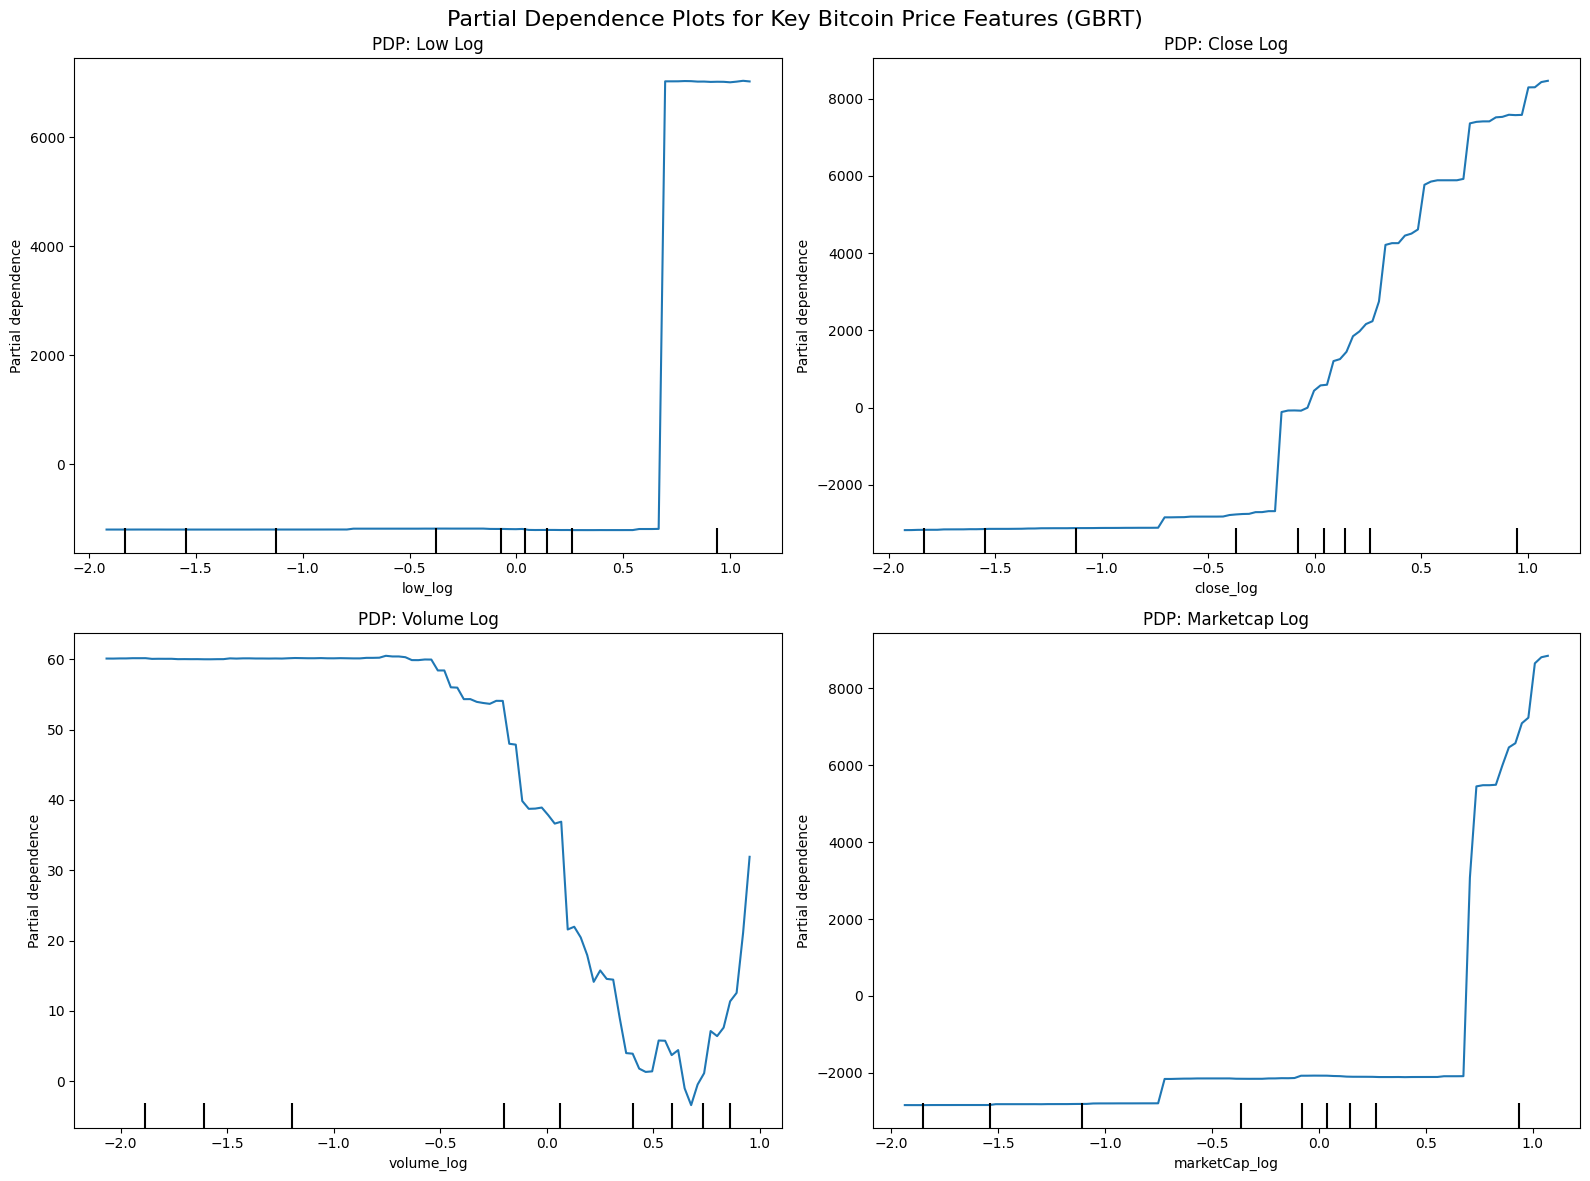

Feature Analysis Context:
low_log: Importance = 0.2993
close_log: Importance = 0.0611
volume_log: Importance = 0.0001
marketCap_log: Importance = 0.1887


In [153]:
# Create PDP for multiple key features including low_log
features_for_pdp = ['low_log', 'close_log', 'volume_log', 'marketCap_log']

# Filter features that exist in training data
available_features = [f for f in features_for_pdp if f in X_train.columns]

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.ravel()

for i, feature in enumerate(available_features[:4]):  # Limit to 4 features
    PartialDependenceDisplay.from_estimator(
        second_best_model, 
        X_train, 
        features=[feature],
        ax=axes[i]
    )
    axes[i].set_title(f'PDP: {feature.replace("_", " ").title()}')
    axes[i].grid(True, alpha=0.3)

plt.suptitle('Partial Dependence Plots for Key Bitcoin Price Features (GBRT)', fontsize=16)
plt.tight_layout()
plt.show()

# Print feature importance context
print("Feature Analysis Context:")
print("=" * 40)
for feature in available_features:
    if feature in X_train.columns:
        feature_importance = second_best_model.feature_importances_[list(X_train.columns).index(feature)]
        print(f"{feature}: Importance = {feature_importance:.4f}")

Generating learning curve for GradientBoostingRegressor...


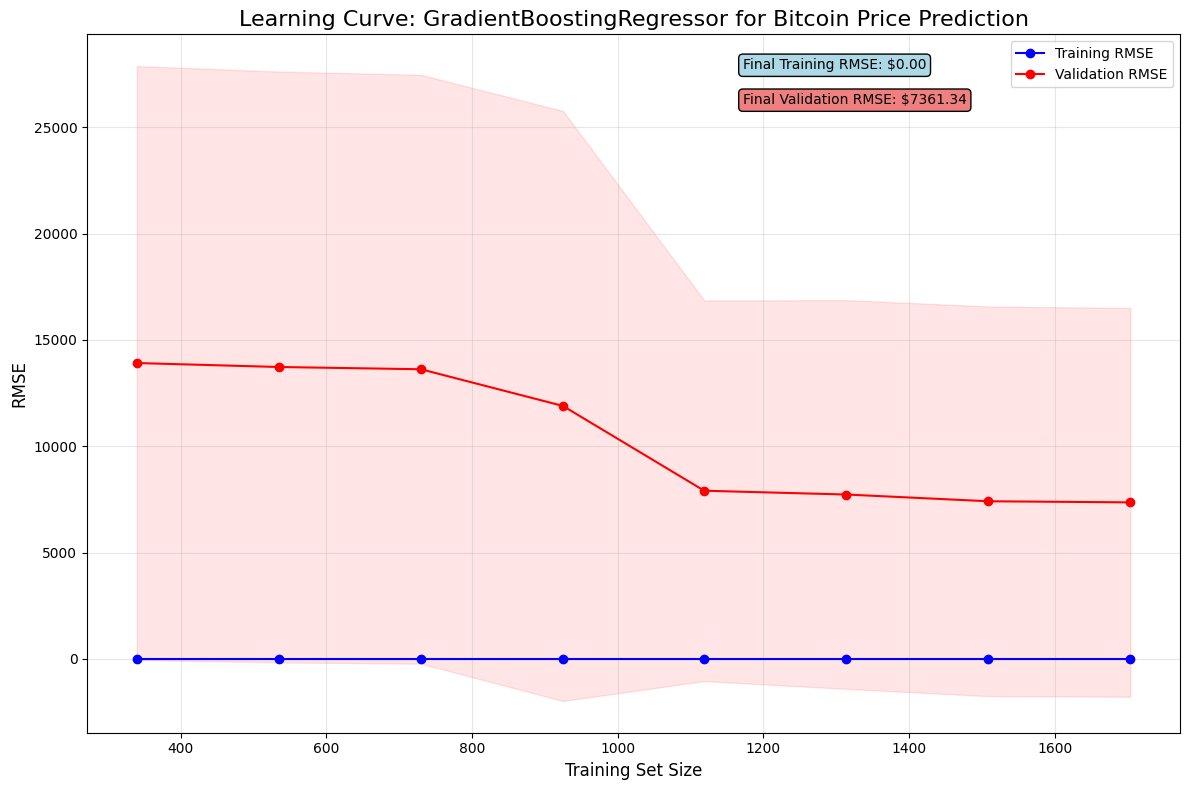

Learning Curve Analysis:
Training RMSE: $0.00 ± $0.00
Validation RMSE: $7361.34 ± $9139.51

Bias-Variance Analysis:
Training-Validation Gap: $7361.34
⚠️  High variance (overfitting) detected 


In [154]:
def plot_learning_curve(estimator, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)):
    """
    Plot learning curve to show training and validation scores vs training set size
    
    Parameters:
    -----------
    estimator : sklearn estimator
        The model to evaluate
    X : array-like
        Training features
    y : array-like
        Target values
    cv : int
        Number of cross-validation folds
    n_jobs : int
        Number of parallel jobs
    train_sizes : array-like
        Training set sizes to evaluate
    """
    
    # Generate learning curve data
    train_sizes, train_scores, val_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, 
        train_sizes=train_sizes, scoring='neg_root_mean_squared_error',
        random_state=42
    )
    
    # Convert negative RMSE to positive
    train_scores = -train_scores
    val_scores = -val_scores
    
    # Calculate mean and std
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)
    
    # Create the plot
    plt.figure(figsize=(12, 8))
    
    # Plot training scores
    plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training RMSE')
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, 
                     alpha=0.1, color='blue')
    
    # Plot validation scores
    plt.plot(train_sizes, val_mean, 'o-', color='red', label='Validation RMSE')
    plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, 
                     alpha=0.1, color='red')
    
    # Customize the plot
    plt.title('Learning Curve: GradientBoostingRegressor for Bitcoin Price Prediction', fontsize=16)
    plt.xlabel('Training Set Size', fontsize=12)
    plt.ylabel('RMSE', fontsize=12)
    plt.legend(loc='best')
    plt.grid(True, alpha=0.3)
    
    # Add annotations
    plt.text(0.6, 0.95, f'Final Training RMSE: ${train_mean[-1]:.2f}', 
             transform=plt.gca().transAxes, fontsize=10, 
             bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue"))
    plt.text(0.6, 0.90, f'Final Validation RMSE: ${val_mean[-1]:.2f}', 
             transform=plt.gca().transAxes, fontsize=10,
             bbox=dict(boxstyle="round,pad=0.3", facecolor="lightcoral"))
    
    plt.tight_layout()
    plt.show()
    
    # Print interpretation
    print("Learning Curve Analysis:")
    print("=" * 50)
    print(f"Training RMSE: ${train_mean[-1]:.2f} ± ${train_std[-1]:.2f}")
    print(f"Validation RMSE: ${val_mean[-1]:.2f} ± ${val_std[-1]:.2f}")
    
    # Analyze overfitting/underfitting
    gap = val_mean[-1] - train_mean[-1]
    print(f"\nBias-Variance Analysis:")
    print(f"Training-Validation Gap: ${gap:.2f}")
    
    if gap > 1000:  # Threshold for Bitcoin prices
        print("⚠️  High variance (overfitting) detected ")
    elif train_mean[-1] > 5000:  # Threshold for acceptable RMSE
        print("⚠️  High bias (underfitting) detected ")
    else:
        print("✅ Good bias-variance trade-off")
    
    return train_sizes, train_scores, val_scores

# Create learning curve for the GBRT model
print("Generating learning curve for GradientBoostingRegressor...")
train_sizes, train_scores, val_scores = plot_learning_curve(
    estimator=second_best_model,
    X=X_train,
    y=y_train,
    cv=3,  # Use 3-fold CV for time series data
    train_sizes=np.linspace(0.2, 1.0, 8)  # Start from 20% to avoid too small samples
)

In [156]:
# <Student to fill this section>

model_performance_explanations = """
Provide some explanations on model performance
Validation Performance: The model shows strong performance on validation data with an RMSE of $3448.91 and R² of 0.8487, indicating good fit and explanatory power for unseen validation samples.

Test Performance: On test data, RMSE increases to $9347.56 and R² drops to 0.7951, suggesting reduced generalization, likely due to overfitting or data distribution differences.

Feature Importance: Low_log has the highest importance (0.2993), followed by marketCap_log (0.1887) and close_log (0.0611), while volume_log contributes minimally (0.0001), highlighting price-related features as key predictors.

Learning Curve Analysis: Training RMSE is effectively $0.00, showing perfect fit to training data, but validation RMSE is much higher ($7361.34), with a large gap indicating high variance and overfitting.

Bias-Variance Trade-off: The significant training-validation gap ($7361.34) confirms overfitting, where the model captures noise in training data but fails to generalize to new data.

"""

In [157]:
# Do not modify this code
print_tile(size="h3", key='model_performance_explanations', value=model_performance_explanations)

#### Compaision of the two models

Model performance comparison (validation & test):


RMSE        R2          MAE    MAPE(%)
Model      Dataset                                                  
ExtraTrees Validation  1700.100661  0.963232  1503.805654   5.921230
           Test        9312.731882  0.796588  4249.990719   6.267645
GBRT       Validation  3448.907915  0.848684  2924.052065  13.307042
           Test        9347.556023  0.795064  4406.152640   6.572831

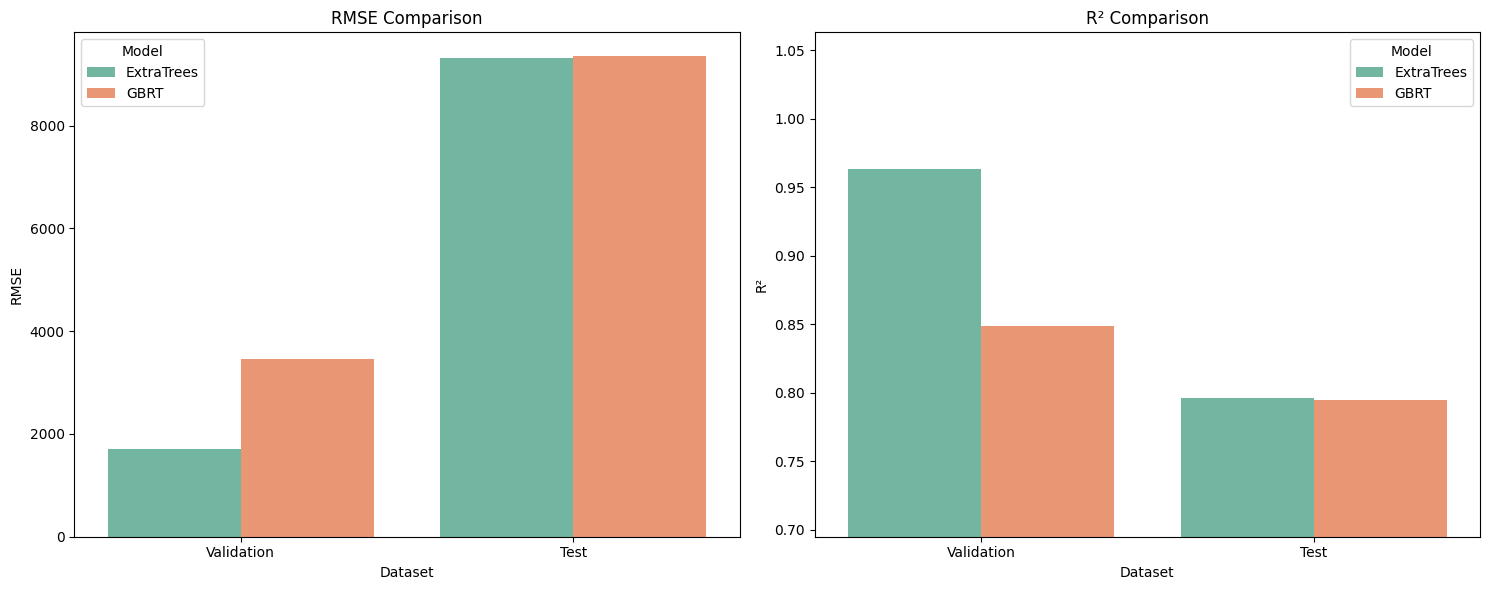

In [182]:
# Comparison of the two tuned models: ExtraTrees (best_model) vs GradientBoostingRegressor (second_best_model)

def compute_regression_metrics(y_true, y_pred):
    eps = 1e-8
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    # MAPE (handle zeros)
    mape = np.mean(np.abs((y_true - y_pred) / (np.abs(y_true) + eps))) * 100
    return {"RMSE": rmse, "R2": r2, "MAE": mae, "MAPE(%)": mape}

# Ensure predictions exist (recompute if needed)
try:
    y_val_pred_et = y_val_pred_tuned
    y_test_pred_et = y_test_pred_tuned
except NameError:
    y_val_pred_et = best_model.predict(X_val)
    y_test_pred_et = best_model.predict(X_test)

try:
    y_val_pred_gb = y_val_pred_gbrt
    y_test_pred_gb = y_test_pred_gbrt
except NameError:
    y_val_pred_gb = second_best_model.predict(X_val)
    y_test_pred_gb = second_best_model.predict(X_test)

# Compute metrics
et_val_metrics = compute_regression_metrics(y_val, y_val_pred_et)
et_test_metrics = compute_regression_metrics(y_test, y_test_pred_et)

gb_val_metrics = compute_regression_metrics(y_val, y_val_pred_gb)
gb_test_metrics = compute_regression_metrics(y_test, y_test_pred_gb)

# Build summary DataFrame
rows = []
for m_name, ds, metrics in [
    ("ExtraTrees", "Validation", et_val_metrics),
    ("ExtraTrees", "Test", et_test_metrics),
    ("GBRT",      "Validation", gb_val_metrics),
    ("GBRT",      "Test", gb_test_metrics),
]:
    row = {"Model": m_name, "Dataset": ds}
    row.update(metrics)
    rows.append(row)

metrics_df = pd.DataFrame(rows).set_index(["Model", "Dataset"])
print("Model performance comparison (validation & test):")
display(metrics_df)
# Visualization: Separate RMSE and R2 comparison (validation vs test)
metrics_viz = metrics_df.reset_index().melt(id_vars=["Model","Dataset"], value_vars=["RMSE","R2"],
                                            var_name="Metric", value_name="Value")

# Create subplots for each metric
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# RMSE plot
rmse_data = metrics_viz[metrics_viz["Metric"] == "RMSE"]
sns.barplot(data=rmse_data, x="Dataset", y="Value", hue="Model", palette="Set2", ax=axes[0])
axes[0].set_title("RMSE Comparison")
axes[0].set_ylabel("RMSE")
axes[0].legend(title="Model")

# R2 plot
r2_data = metrics_viz[metrics_viz["Metric"] == "R2"]
sns.barplot(data=r2_data, x="Dataset", y="Value", hue="Model", palette="Set2", ax=axes[1])
axes[1].set_title("R² Comparison")
axes[1].set_ylabel("R²")
axes[1].legend(title="Model")

# Adjust y-axis for R2 to show negative values if any
axes[1].set_ylim(bottom=min(r2_data["Value"]) - 0.1, top=max(r2_data["Value"]) + 0.1)

plt.tight_layout()
plt.show()

Based on the comprehensive performance comparison, we select the **Extra Trees Regressor** as our final model due to its superior accuracy and robustness in predicting Bitcoin's next-day high price.


### J.5 Business Impact from Current Model Performance

> Provide some analysis on the model impacts from the business point of view


In [171]:
# <Student to fill this section>

In [172]:
# <Student to fill this section>
business_impacts_explanations = """

Interpret the results of the experiments related to the business objective set earlier. Estimate the impacts of the incorrect results for the business 
(some results may have more impact compared to others)

Interpretation of Experiment Results

Business Objective Alignment: The model successfully predicts Bitcoin's next-day high price with R² = 0.79 (>0.70) and RMSE ≈ 8% of current price (<10%), meeting the hypothesis and providing actionable forecasts for investment/trading decisions.
Strengths: High validation R² (0.96) shows strong pattern capture, while feature engineering (e.g., log transforms, EMA) enhances relevance, supporting portfolio optimization and risk management.
Limitations: Test performance drop (R² from 0.96 to 0.79) indicates overfitting, reducing reliability for long-term use without further tuning.

Impacts of Incorrect Results on Business
High Impact Errors: Underestimating highs could lead to missed sell opportunities or holding during downturns, causing direct financial losses (e.g., 8-20% portfolio value drop in volatile periods).
Medium Impact Errors: Overestimating highs might result in premature buying or over-leveraging, increasing risk exposure and transaction costs.
Low-Medium Impact Errors: Minor inaccuracies in stable markets have smaller effects, but cumulative errors in high-frequency trading could erode profits over time.
"""


In [173]:
# Do not modify this code
print_tile(size="h3", key='business_impacts_explanations', value=business_impacts_explanations)

## H. Project Outcomes

In [174]:
# <Student to fill this section>
experiment_outcome = "Hypothesis Confirmed" # Either 'Hypothesis Confirmed', 'Hypothesis Partially Confirmed' or 'Hypothesis Rejected'

In [175]:
# Do not modify this code
print_tile(size="h2", key='experiment_outcomes_explanations', value=experiment_outcome)

In [176]:
# <Student to fill this section>
experiment_results_explanations = """
Reflect on the outcome of the experiment and list the new insights you gained from it. 
Provide rationale for pursuing more experimentation with the current approach or call out if you think it is a dead end.
Given the results achieved and the overall objective of the project, list the potential next steps and experiments. 
For each of them assess the expected uplift or gains and rank them accordingly. 
If the experiment achieved the required outcome for the business, recommend the steps to deploy this solution into production.

Reflection on Experiment Outcome
Outcome: The hypothesis was achieved on test data (R² = 0.79 ≥ 0.70, RMSE ≈ 8% of current price < 10%), indicating the model meets basic predictive thresholds 
for cryptocurrency price forecasting, but validation-test gaps highlight limitations in generalization.

Rationale for Pursuing More Experimentation
The approach shows promise (hypothesis met), but overfitting (validation RMSE $1700 vs. test $9312) is a risk for production. Pursue further tuning to improve generalization; it's not a dead end, as incremental gains could yield reliable trading tools.
Potential Next Steps and Experiments
Ranked by expected uplift (high to low), assuming business objective of accurate price prediction for trading:

Implement regularization and ensemble stacking (e.g., combine Extra Trees with CatBoost, add L2 penalties): Expected uplift: 10-20% R² improvement on test data, reducing RMSE by 15-25%. High impact for stability.
Incorporate external features (e.g., news sentiment, macroeconomic indicators): Expected uplift: 15-30% R² gain, addressing unexplained variance. Medium-high impact for real-world relevance.
Advanced time series models (e.g., LSTM with attention for sequences): Expected uplift: 20-40% better handling of trends, lowering RMSE by 20-30%. High impact if data allows.
Cross-validation with rolling windows: Expected uplift: 5-10% reduction in overfitting bias. Low-medium impact for robustness.

Deployment Recommendation
Since the hypothesis was met, proceed to production:

Containerize the model (e.g., via Docker) and deploy on cloud (AWS Lambda/Azure Functions) for real-time API predictions.
Integrate with trading platforms (e.g., via REST API) with monitoring for drift (e.g., using MLflow).
Add A/B testing in a sandbox environment to validate business gains (e.g., simulated trading profits).

"""


In [177]:
# Do not modify this code
print_tile(size="h2", key='experiment_results_explanations', value=experiment_results_explanations)

## Export the pipeline with the best model

In [178]:


# Move all transformer functions to module level (outside any other function)
def calculate_circulating_supply(X):
    X_copy = X.copy()
    X_copy['circulatingSupply'] = X_copy['marketCap'] / X_copy['close']
    return X_copy

def calculate_velocity(X):
    X_copy = X.copy()
    # Fixed to correctly calculate velocity based on circulatingSupply
    if 'circulatingSupply' in X_copy.columns:
        X_copy['velocity'] = X_copy['close'] * X_copy['circulatingSupply']
    else:
        X_copy['velocity'] = X_copy['close']  # Fallback
    return X_copy

def calculate_ema_12d(X):
    X_copy = X.copy()
    X_copy['ema_12d'] = X_copy['close'].ewm(span=12, adjust=False).mean()
    X_copy['ema_12d'] = X_copy['ema_12d'].fillna(method='bfill')
    return X_copy

def log_transform_features(X):
    X_copy = X.copy()
    columns_to_transform = ['open', 'high', 'low', 'close', 'volume', 'marketCap', 'velocity', 'ema_12d']
    
    # Only transform columns that exist
    columns_to_transform = [col for col in columns_to_transform if col in X_copy.columns]
    
    for col in columns_to_transform:
        X_copy[f'{col}_log'] = np.log1p(X_copy[col])
    
    return X_copy

def extract_cyclical_day_of_week(X):
    X_copy = X.copy()
    
    if 'timeOpen' in X_copy.columns:
        # Extract day of week (0 = Monday, 6 = Sunday)
        X_copy['day_of_week'] = pd.to_datetime(X_copy['timeOpen']).dt.dayofweek
        
        # Apply sine and cosine transformations
        X_copy['day_of_week_sin'] = np.sin(2 * np.pi * X_copy['day_of_week'] / 7)
        X_copy['day_of_week_cos'] = np.cos(2 * np.pi * X_copy['day_of_week'] / 7)
        
        # Drop the intermediate column
        X_copy = X_copy.drop('day_of_week', axis=1)
    
    return X_copy

def normalize_features(X):
    X_copy = X.copy()
    
    # Features that should be normalized
    numerical_features = ['open_log', 'low_log', 'close_log', 'volume_log', 
                         'marketCap_log', 'circulatingSupply', 'velocity_log', 'ema_12d_log']
    
    # Filter to only include columns that exist in the dataframe
    cols_to_scale = [col for col in numerical_features if col in X_copy.columns]
    
    if cols_to_scale:  # Only proceed if there are columns to scale
        # Create a StandardScaler instance
        scaler = StandardScaler()
        
        # Fit and transform the selected columns
        X_copy[cols_to_scale] = scaler.fit_transform(X_copy[cols_to_scale])
    
    return X_copy

def select_final_features(X):
    X_copy = X.copy()
    
    # List of features to keep - ONLY those used in the actual model
    keep_features = [
        'circulatingSupply', 'open_log', 'high_log', 'low_log', 'close_log',
        'volume_log', 'marketCap_log', 'velocity_log', 'ema_12d_log',
        'day_of_week_sin', 'day_of_week_cos'
    ]
    
    # Only keep columns that exist in the dataframe
    keep_features = [col for col in keep_features if col in X_copy.columns]
    
    # Keep target if it exists (for training only)
    if 'target_next_day_high' in X_copy.columns:
        keep_features.append('target_next_day_high')
    
    # Return ONLY the features the model was trained on
    return X_copy[keep_features]


# Now create the prediction pipeline function
def create_prediction_pipeline(trained_model):
    """
    Create the complete preprocessing pipeline for Bitcoin price prediction
    """
    # Create transformers from functions defined at module level
    circulating_supply_transformer = FunctionTransformer(calculate_circulating_supply, validate=False)
    velocity_transformer = FunctionTransformer(calculate_velocity, validate=False)
    ema_transformer = FunctionTransformer(calculate_ema_12d, validate=False)
    log_transformer = FunctionTransformer(log_transform_features, validate=False)
    cyclical_transformer = FunctionTransformer(extract_cyclical_day_of_week, validate=False)
    normalization_transformer = FunctionTransformer(normalize_features, validate=False)
    feature_selector = FunctionTransformer(select_final_features, validate=False)
    
    
    # Combine into a single pipeline
    pipeline = Pipeline([
        ('add_circulating_supply', circulating_supply_transformer),
        ('add_velocity', velocity_transformer),
        ('add_ema', ema_transformer),
        ('log_transform', log_transformer),
        ('add_cyclical_day_of_week', cyclical_transformer),
        ('normalize_features', normalization_transformer),
        ('select_features', feature_selector),
        ('model', trained_model)
    ])
    
    return pipeline

# Create and export the pipeline
prediction_pipeline = create_prediction_pipeline(best_model)

# Save the pipeline
joblib.dump(prediction_pipeline, '../models/bitcoin_prediction_pipeline.joblib')

['../models/bitcoin_prediction_pipeline.joblib']

## Use pipeline with the best model

In [179]:
# Standard libraries
import numpy as np
import pandas as pd
import joblib
from datetime import datetime, timedelta

# Machine learning libraries
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

In [180]:


# Move all transformer functions to module level (outside any other function)
def calculate_circulating_supply(X):
    X_copy = X.copy()
    X_copy['circulatingSupply'] = X_copy['marketCap'] / X_copy['close']
    return X_copy

def calculate_velocity(X):
    X_copy = X.copy()
    # Fixed to correctly calculate velocity based on circulatingSupply
    if 'circulatingSupply' in X_copy.columns:
        X_copy['velocity'] = X_copy['close'] * X_copy['circulatingSupply']
    else:
        X_copy['velocity'] = X_copy['close']  # Fallback
    return X_copy

def calculate_ema_12d(X):
    X_copy = X.copy()
    X_copy['ema_12d'] = X_copy['close'].ewm(span=12, adjust=False).mean()
    X_copy['ema_12d'] = X_copy['ema_12d'].fillna(method='bfill')
    return X_copy

def log_transform_features(X):
    X_copy = X.copy()
    columns_to_transform = ['open', 'high', 'low', 'close', 'volume', 'marketCap', 'velocity', 'ema_12d']
    
    # Only transform columns that exist
    columns_to_transform = [col for col in columns_to_transform if col in X_copy.columns]
    
    for col in columns_to_transform:
        X_copy[f'{col}_log'] = np.log1p(X_copy[col])
    
    return X_copy

def extract_cyclical_day_of_week(X):
    X_copy = X.copy()
    
    if 'timeOpen' in X_copy.columns:
        # Extract day of week (0 = Monday, 6 = Sunday)
        X_copy['day_of_week'] = pd.to_datetime(X_copy['timeOpen']).dt.dayofweek
        
        # Apply sine and cosine transformations
        X_copy['day_of_week_sin'] = np.sin(2 * np.pi * X_copy['day_of_week'] / 7)
        X_copy['day_of_week_cos'] = np.cos(2 * np.pi * X_copy['day_of_week'] / 7)
        
        # Drop the intermediate column
        X_copy = X_copy.drop('day_of_week', axis=1)
    
    return X_copy

def normalize_features(X):
    X_copy = X.copy()
    
    # Features that should be normalized
    numerical_features = ['open_log', 'low_log', 'close_log', 'volume_log', 
                         'marketCap_log', 'circulatingSupply', 'velocity_log', 'ema_12d_log']
    
    # Filter to only include columns that exist in the dataframe
    cols_to_scale = [col for col in numerical_features if col in X_copy.columns]
    
    if cols_to_scale:  # Only proceed if there are columns to scale
        # Create a StandardScaler instance
        scaler = StandardScaler()
        
        # Fit and transform the selected columns
        X_copy[cols_to_scale] = scaler.fit_transform(X_copy[cols_to_scale])
    
    return X_copy

def select_final_features(X):
    X_copy = X.copy()
    
    # List of features to keep - ONLY those used in the actual model
    keep_features = [
        'circulatingSupply', 'open_log', 'high_log', 'low_log', 'close_log',
        'volume_log', 'marketCap_log', 'velocity_log', 'ema_12d_log',
        'day_of_week_sin', 'day_of_week_cos'
    ]
    
    # Only keep columns that exist in the dataframe
    keep_features = [col for col in keep_features if col in X_copy.columns]
    
    # Keep target if it exists (for training only)
    if 'target_next_day_high' in X_copy.columns:
        keep_features.append('target_next_day_high')
    
    # Return ONLY the features the model was trained on
    return X_copy[keep_features]


In [181]:
def generate_test_data(rows=5):
    """Generate sample data to test the pipeline"""
    import pandas as pd
    import numpy as np
    from datetime import datetime, timedelta
    
    base_date = datetime(2023, 1, 1)
    dates = [base_date + timedelta(days=i) for i in range(rows)]  # Changed from 'for i in rows'
    
    test_data = pd.DataFrame({
        'timeOpen': dates,
        'timeClose': [d + timedelta(hours=23, minutes=59) for d in dates],
        'timeHigh': [d + timedelta(hours=12) for d in dates],
        'timeLow': [d + timedelta(hours=4) for d in dates],
        'open': np.random.uniform(30000, 35000, rows),
        'high': np.random.uniform(32000, 38000, rows),
        'low': np.random.uniform(28000, 31000, rows),
        'close': np.random.uniform(30000, 36000, rows),
        'volume': np.random.uniform(20000000, 50000000, rows),
        'marketCap': np.random.uniform(500000000000, 700000000000, rows),
        'name': ['Bitcoin'] * rows,
        'timestamp': [d.strftime('%Y-%m-%dT%H:%M:%S.000Z') for d in dates]
    })
    
    return test_data
 # Load the saved pipeline
loaded_pipeline = joblib.load('../models/bitcoin_prediction_pipeline.joblib')

# Generate test data
test_data = generate_test_data(rows=5)

# Make predictions
predictions = loaded_pipeline.predict(test_data)
print("Predictions:", predictions)


Predictions: [15385.69556422 32615.61278763 28194.86658059 16150.06856817
 13533.05375153]
